# 1. Configuración de entorno

En esta sección validamos que nuestro entorno de trabajo esté correctamente configurado antes de comenzar el análisis.  
Los pasos incluyen:

1. **Versión de Python**  
   - Se verifica que esté instalada la versión **3.11 o superior** (se recomienda 3.13).  
   - Esto garantiza compatibilidad con librerías modernas de análisis de datos y machine learning.

2. **Importación de librerías base**  
   - Se cargan librerías fundamentales:  
     - `numpy`, `pandas`: manipulación y análisis de datos.  
     - `matplotlib`, `seaborn`: visualización de datos.  
     - `scipy`: funciones estadísticas.  
   - Además se configuran estilos gráficos y opciones de visualización en pandas para trabajar con tablas más grandes.

3. **Verificación de versiones críticas**  
   - Se comprueba que `scikit-learn` esté instalado y en una versión **>= 1.0.1**.  
   - Esto es esencial ya que `scikit-learn` se usará para el modelado (baseline y posteriores).

Con esta configuración inicial aseguramos que el entorno sea reproducible y que todas las dependencias necesarias estén listas antes de continuar con el **EDA** y el **baseline**.


In [301]:
import sys
import warnings
warnings.filterwarnings('ignore')

assert sys.version_info >= (3, 11), "Este notebook trabajo con python 3.11 o superiores (recomendado 3.13)"

print(f"Python {sys.version_info.major}.{sys.version_info.minor} instalado correctamente")

Python 3.13 instalado correctamente


In [302]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Librerías importadas exitosamente")

Librerías importadas exitosamente


In [303]:
# Verificar versiones de librerías críticas
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1"), "Requiere scikit-learn >= 1.0.1"
print(f"scikit-learn {sklearn.__version__} instalado")

scikit-learn 1.7.2 instalado


# 2. Metodología CRISP-DM
## 2.1. Comprensión del Negocio
El problema de Google Play Store  

**Contexto:**  
Es 2025. El mercado de aplicaciones móviles es altamente competitivo: millones de apps conviven en Google Play Store.  
Los desarrolladores buscan mejorar la visibilidad de sus aplicaciones y los usuarios dependen del **rating promedio** para decidir qué descargar.  

**Problema actual:**  
- El rating se conoce **solo después** de que los usuarios descargan y reseñan.  
- Las valoraciones son **altamente variables** y pueden depender de múltiples factores (categoría, descargas, precio, tamaño, tipo de app).  
- Los desarrolladores carecen de una herramienta para **estimar la calificación potencial** de una app antes o durante su lanzamiento.  
- La competencia es muy alta: una diferencia de décimas en rating puede significar miles de descargas menos.  

---

### 2.1.1. Solución propuesta  
Construir un **sistema automático de predicción de rating** de apps a partir de sus características disponibles en el dataset de Google Play Store.  

---

### 2.1.2. Definiendo el éxito  

**Métrica de negocio:**  
- Ayudar a los desarrolladores a anticipar la valoración probable de su app.  
- Reducir la dependencia de pruebas de mercado costosas o lentas.  
- Identificar características clave que favorecen una alta valoración (≥ 4.3).  

**Métrica técnica:**  
- Lograr un **Error Absoluto Medio (MAE) < 0.5 estrellas** en la predicción de rating.  
- Para la versión de clasificación (alta vs. baja calificación): obtener un **F1-score > 0.70**.  

**¿Por qué estos valores?**  
- El rating va de 1 a 5 → un error de 0.5 equivale a 10% de la escala.  
- Una diferencia de medio punto puede marcar la visibilidad de la app en el ranking.  
- Tasadores humanos (usuarios) también muestran variabilidad similar en sus calificaciones.  

---

### 2.1.3 Preguntas críticas antes de empezar  

1. **¿Realmente necesitamos ML?**  
   - Alternativa 1: Calcular el promedio de ratings por categoría → demasiado simple, no captura variabilidad.  
   - Alternativa 2: Reglas heurísticas (ej. “si es gratis y tiene muchas descargas, tendrá rating alto”) → insuficiente.  
   - **Conclusión:** Sí, ML es apropiado para capturar relaciones no lineales y múltiples factores.  

2. **¿Qué pasa si el modelo falla?**  
   - Transparencia: aclarar que es una estimación automática.  
   - Complementar con rangos de predicción (ej: intervalo de confianza).  
   - Mantener como referencia comparativa, no como único criterio de éxito.  

3. **¿Cómo mediremos el impacto?**  
   - Capacidad de anticipar apps con alta probabilidad de éxito.  
   - Ahorro de tiempo en validaciones preliminares.  
   - Insights para desarrolladores sobre qué factores influyen más en el rating.  

---


## 2.2. Comprensión de los Datos  

El objetivo de esta fase es explorar y entender el dataset de Google Play Store antes de construir modelos **(análisis exploratorio)**.  
Nos centraremos en:  

1. **Vista rápida del dataset**  
   - Identificar dimensiones (filas × columnas).  
   - Tipos de datos (numéricos, categóricos, texto, fechas).  
   - Valores faltantes obvios y rangos sospechosos.

2. **Descripción de variables**  
   - Revisar cada columna y entender su significado.  
   - Detectar qué variables podrían ser útiles como predictores y cuál será la variable objetivo (rating).  

3. **Detección de problemas en los datos**  
   - Análisis de valores faltantes.  
   - Estrategias: eliminar filas/columnas, imputar valores o crear indicadores de “dato faltante”.  

4. **Estadísticas descriptivas y univariadas**  
   - Media vs mediana (sesgo de la distribución).  
   - Desviación estándar (variabilidad, posibles outliers).  
   - Mínimos/máximos sospechosos.  
   - Histogramas para ver forma (normal, sesgada, bimodal, uniforme, picos extraños).  

5. **Análisis de variables categóricas**  
   - Distribución de categorías (ej. categorías de apps, tipo de app, content rating).  
   - Detección de clases dominantes o categorías poco representadas.  

6. **Correlaciones y relaciones entre variables**  
   - Matriz de correlación de Pearson para variables numéricas.  
   - Identificar relaciones fuertes, moderadas o débiles.  
   - Importante: recordar que **correlación ≠ causalidad**.  
7. **Análisis de outliers**
   -  Tipos e identificación de outliers a través de diferentes métodos.

---

**Nota:**  
No siempre es necesario aplicar todos los pasos con igual profundidad.  
- Para este proyecto, el foco está en **identificar variables relevantes para predecir el rating** y **limpiar datos inconsistentes**.  
- Otros análisis más complejos (ej. NLP sobre descripciones) se pueden dejar como trabajo futuro (según trabajos de referencia investigados).

---


### 2.2.1 Descarga de datos  

En este paso descargamos el dataset de Google Play Store desde Kaggle y lo organizamos en la estructura de carpetas del proyecto.  

1. Usamos la librería `kagglehub` para acceder al dataset público **`lava18/google-play-store-apps`** directamente desde Kaggle.  
2. Se define una ruta clara dentro del proyecto para almacenar los datos originales: `../data/original/google-play-store/`. Esto ayuda a mantener la reproducibilidad y una estructura organizada.  
3. Con la función `shutil.copytree` copiamos los archivos descargados a la carpeta destino. De esta forma, el dataset queda disponible en nuestro directorio de trabajo para su análisis posterior.  


In [304]:
import kagglehub
import shutil

def download_data(origin_repository, target_folder):
    # Descargar dataset
    path = kagglehub.dataset_download(origin_repository)
    
    # Copiar los archivos descargados
    shutil.copytree(path, target_folder, dirs_exist_ok=True)
    

download_data("lava18/google-play-store-apps", "../../data/original/google-play-store")

### 2.2.2 Carga de datos  

En este paso realizamos la **lectura del archivo CSV** que contiene el dataset descargado previamente.  

- Definimos una función `load_data(path, file)` que recibe la ruta y el nombre del archivo, y lo carga con `pandas.read_csv()`.  
- Cargamos el dataset principal en la variable `applications_data` desde la carpeta `../data/original/google-play-store/`.  
- Incluimos una verificación simple:  
  - Si el dataset se carga con éxito, se imprime `"Dataset loaded"`.  
  - En caso contrario, se muestra un mensaje de error.  

Con esta validación aseguramos que el archivo esté disponible y correctamente leído antes de continuar con el análisis exploratorio.


In [305]:
import pandas as pd
import numpy as np

def load_data(path, file):
    return pd.read_csv(f"{path}/{file}")

def convert_numeric_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convierte a numéricas solo las columnas que deberían serlo, sin tocar 'Size'.
    Usa to_numeric(errors='coerce') para evitar ValueError si aparece texto.
    """
    df = df.copy()

    # Rating
    if "Rating" in df.columns:
        df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")

    # Reviews: quitar comas y cualquier carácter no numérico/punto
    if "Reviews" in df.columns:
        df["Reviews"] = (
            df["Reviews"].astype(str)
            .str.replace(r"[^\d.]", "", regex=True)
            .pipe(pd.to_numeric, errors="coerce")
        )

    # Installs: quitar +, comas y cualquier carácter no numérico/punto
    if "Installs" in df.columns:
        df["Installs Numeric"] = (
            df["Installs"].astype(str)
            .str.replace(r"[^\d.]", "", regex=True)
            .pipe(pd.to_numeric, errors="coerce")
        )

    # Price: quitar $ y cualquier carácter no numérico/punto
    if "Price" in df.columns:
        df["Price"] = (
            df["Price"].astype(str)
            .str.replace(r"[^\d.]", "", regex=True)
            .pipe(pd.to_numeric, errors="coerce")
        )


    if "Size" in df.columns:
        def parse_size(x):
            if isinstance(x, str):
                x = x.strip()
                if x.endswith("M"):
                    return float(x[:-1])
                elif x.endswith("k") or x.endswith("K"):
                    return float(x[:-1]) / 1024  # KB -> MB
                else:
                    return np.nan
            return np.nan
        df["Size"] = df["Size"].apply(parse_size)

    return df


temp_applications_data = load_data("../../data/original/google-play-store", "googleplaystore.csv")
applications_data = convert_numeric_columns(temp_applications_data)


if len(applications_data):
    print("Dataset cargado")
else:
    print("Error cargando dataset")


Dataset cargado


### 2.2.3 Vista rápida del dataset

**Dimensiones y columnas**
- Registros: **10,841** filas.
- Columnas: actualmente **14**; **originalmente eran 13** y se **añadió** una columna derivada: **`Installs Numeric`** para análisis con describe.
- Memoria aproximada: **~1.2 MB**.

**Tipos de datos (y transformaciones realizadas)**
- Numéricas (`float64`): `Rating`, `Reviews`, `Size`, `Price`, **`Installs Numeric`**.
- Categóricas / texto (`object`): `App`, `Category`, `Installs` *(forma original con “1,000+”)*, `Type`, `Content Rating`, `Genres`, `Last Updated`, `Current Ver`, `Android Ver`.
- Transformaciones ya aplicadas:
  - **`Installs`** se **conservó** en su formato original (categórico con “+” y comas) **y** se creó **`Installs Numeric`** mapeando esos rangos a números (0 … 1,000,000,000).
  - **`Price`**, **`Reviews`** y **`Size`** fueron normalizadas/parseadas a **numérico** para análisis y modelado.

**Valores faltantes (no-null count → faltantes aprox.)**
- `Rating`: 9,367 → **1,474 faltantes (~13.6%)**.
- `Size`: 9,145 → **1,696 faltantes (~15.6%)**.
- `Current Ver`: 10,833 → **8 faltantes (~0.07%)**.
- `Android Ver`: 10,838 → **3 faltantes (~0.03%)**.
- `Content Rating`: 10,840 → **1 faltante (~0.01%)**.
- `Price`: 10,840 → **1 faltante (~0.01%)**.
- `Installs Numeric`: 10,840 → **1 faltante (~0.01%)**.
- Resto de columnas: **sin faltantes**.

**Duplicados:**
-   Se identificaron **483 filas duplicadas** (≈ **4.46%** del
    dataset).\
-   Ejemplos de duplicados incluyen apps como:
    -   *Quick PDF Scanner + OCR FREE*\
    -   *Box*\
    -   *Google My Business*\
    -   *ZOOM Cloud Meetings*\
    -   *join.me -- Simple Meetings*\

**Rangos y valores sospechosos (según `describe()`)**
- `Rating`: **min = 1.0**, **max = 19.0** → **19** es inválido para la escala 1–5 (error de dato a corregir).
- `Reviews`: media ~ **444k**, **p75 ≈ 54,768**, **max ≈ 78M** → valores altos plausibles; tratar como **outliers**.
- `Size` (MB): media ~ **21.5**, **p50 = 13**, **p75 = 30**, **max = 100** → distribución sesgada a la derecha; mínimos muy bajos (**0.01**) a revisar.
- `Price` (USD): **mediana = 0** y **p75 = 0** → la mayoría son **apps gratuitas**; **max = 400** sugiere outliers de precio.
- `Installs Numeric`: **p25 = 1,000**, **p50 = 100,000**, **p75 = 5,000,000**, **max = 1,000,000,000** → escala muy amplia; conviene usar **transformaciones log** o **binning** en el EDA/modelado.

**Conclusión inicial**
- Los **faltantes** más relevantes están en `Rating` y `Size`; habrá que decidir estategía para aumentar, imputar o nivelar los datos.
- Existen **outliers (no legítimos)** (ej. `Rating = 19`) y variables con **colas largas** (ej. `Reviews`, `Installs Numeric`, `Price`).
- Eliminar **duplicados** para evitar sesgos de análisis y que no introduzcan ruidos.


In [6]:
print("=" * 80)
print("INFORMACIÓN GENERAL DEL DATASET".center(80))
print("=" * 80)

display(applications_data.head().style.background_gradient(cmap='RdYlGn', subset=['Rating']))

# Información detallada
print("\n" + "=" * 80)
print("ESTRUCTURA DE DATOS".center(80))
print("=" * 80)
applications_data.info()

# Estadísticas descriptivas
print("\n" + "=" * 80)
print("ESTADÍSTICAS DESCRIPTIVAS".center(80))
print("=" * 80)
display(applications_data.describe().round(2).T)

print("\n" + "=" * 80)
print("DATOS DUPLICADOS".center(80))
print("=" * 80)

# Contar duplicados
num_duplicados = applications_data.duplicated().sum()
print(f"Total de registros duplicados: {num_duplicados}")

# Mostrar ejemplos de duplicados si existen
if num_duplicados > 0:
    print("\nEjemplos de filas duplicadas:\n")
    display(applications_data[applications_data.duplicated()].head())
else:
    print("No se encontraron registros duplicados.")


                        INFORMACIÓN GENERAL DEL DATASET                         


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Installs Numeric
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.100000,159.000000,19.000000,"10,000+",Free,0.000000,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,10000.000000
1,Coloring book moana,ART_AND_DESIGN,3.900000,967.000000,14.000000,"500,000+",Free,0.000000,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,500000.000000
2,"U Launcher Lite – FREE Live Cool Themes, Hide Apps",ART_AND_DESIGN,4.700000,87510.000000,8.700000,"5,000,000+",Free,0.000000,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,5000000.000000
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.500000,215644.000000,25.000000,"50,000,000+",Free,0.000000,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,50000000.000000
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.300000,967.000000,2.800000,"100,000+",Free,0.000000,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,100000.000000



                              ESTRUCTURA DE DATOS                               
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   App               10841 non-null  object 
 1   Category          10841 non-null  object 
 2   Rating            9367 non-null   float64
 3   Reviews           10841 non-null  float64
 4   Size              9145 non-null   float64
 5   Installs          10841 non-null  object 
 6   Type              10840 non-null  object 
 7   Price             10840 non-null  float64
 8   Content Rating    10840 non-null  object 
 9   Genres            10841 non-null  object 
 10  Last Updated      10841 non-null  object 
 11  Current Ver       10833 non-null  object 
 12  Android Ver       10838 non-null  object 
 13  Installs Numeric  10840 non-null  float64
dtypes: float64(5), object(9)
memory usage: 1.2+ MB

    

,count,mean,std,min,25%,50%,75%,max
Rating,9367.00,4.19,0.54,1.00,4.00,4.30,4.50,19.00
Reviews,10841.00,444111.93,2927628.66,0.00,38.00,2094.00,54768.00,78158306.00
Size,9145.00,21.52,22.59,0.01,4.90,13.00,30.00,100.00
Price,10840.00,1.03,15.95,0.00,0.00,0.00,0.00,400.00
Installs Numeric,10840.00,15464338.88,85029361.40,0.00,1000.00,100000.00,5000000.00,1000000000.00



                                DATOS DUPLICADOS                                
Total de registros duplicados: 483

Ejemplos de filas duplicadas:



,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Installs Numeric
229,Quick PDF Scanner + OCR FREE,BUSINESS,4.20,80805.00,NaN,"5,000,000+",Free,0.00,Everyone,Business,"February 26, 2018",Varies with device,4.0.3 and up,5000000.00
236,Box,BUSINESS,4.20,159872.00,NaN,"10,000,000+",Free,0.00,Everyone,Business,"July 31, 2018",Varies with device,Varies with device,10000000.00
239,Google My Business,BUSINESS,4.40,70991.00,NaN,"5,000,000+",Free,0.00,Everyone,Business,"July 24, 2018",2.19.0.204537701,4.4 and up,5000000.00
256,ZOOM Cloud Meetings,BUSINESS,4.40,31614.00,37.00,"10,000,000+",Free,0.00,Everyone,Business,"July 20, 2018",4.1.28165.0716,4.0 and up,10000000.00
261,join.me - Simple Meetings,BUSINESS,4.00,6989.00,NaN,"1,000,000+",Free,0.00,Everyone,Business,"July 16, 2018",4.3.0.508,4.4 and up,1000000.00


### 2.2.4 Descripción de las variables

In [7]:
variables = [
    'App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price',
    'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver',
    'Installs Numeric'
]

tipos = [
    'Categórica',          # App
    'Categórica',          # Category
    'Numérica (Target)',   # Rating
    'Numérica',            # Reviews
    'Numérica (MB)',       # Size
    'Categórica (rango)',  # Installs
    'Categórica',          # Type
    'Numérica (USD)',      # Price
    'Categórica',          # Content Rating
    'Categórica',          # Genres
    'Texto (fecha)',       # Last Updated (parseable a fecha)
    'Texto',               # Current Ver
    'Texto',               # Android Ver
    'Numérica',            # Installs Numeric
]

descripciones = [
    'Nombre de la aplicación.',
    'Categoría oficial de la app en Google Play.',
    'Calificación promedio de usuarios (1 a 5).',
    'Número de reseñas reportadas.',
    'Tamaño aproximado de la app en MB.',
    'Instalaciones en rango (p.ej., "1,000+").',
    'Tipo de app (Free / Paid).',
    'Precio en USD (0 para gratuitas).',
    'Clasificación de contenido (Everyone, Teen, etc.).',
    'Género(s) de la app.',
    'Fecha de última actualización (texto en origen).',
    'Versión actual declarada por el desarrollador.',
    'Versión mínima de Android requerida.',
    'Instalaciones convertidas a número para análisis.'
]

valores_faltantes = [applications_data[col].isnull().sum() if col in applications_data.columns else None for col in variables]

metadata = {
    'Variable': variables,
    'Tipo': tipos,
    'Descripción': descripciones,
    'Valores Faltantes': valores_faltantes
}

df_metadata = pd.DataFrame(metadata)

# Mostrar con resaltado de faltantes
styled = df_metadata.style.applymap(
    lambda x: 'background-color: #ffcccc' if isinstance(x, (int, float)) and x > 0 else '',
    subset=['Valores Faltantes']
)

display(styled)

# Resumen de dtypes originales (informativo)
dtypes_resumen = applications_data[variables].dtypes.astype(str).reset_index()
dtypes_resumen.columns = ['Variable', 'dtype pandas']
display(dtypes_resumen)

,Variable,Tipo,Descripción,Valores Faltantes
0,App,Categórica,Nombre de la aplicación.,0
1,Category,Categórica,Categoría oficial de la app en Google Play.,0
2,Rating,Numérica (Target),Calificación promedio de usuarios (1 a 5).,1474
3,Reviews,Numérica,Número de reseñas reportadas.,0
4,Size,Numérica (MB),Tamaño aproximado de la app en MB.,1696
5,Installs,Categórica (rango),"Instalaciones en rango (p.ej., ""1,000+"").",0
6,Type,Categórica,Tipo de app (Free / Paid).,1
7,Price,Numérica (USD),Precio en USD (0 para gratuitas).,1
8,Content Rating,Categórica,"Clasificación de contenido (Everyone, Teen, etc.).",1
9,Genres,Categórica,Género(s) de la app.,0


,Variable,dtype pandas
0,App,object
1,Category,object
2,Rating,float64
3,Reviews,float64
4,Size,float64
5,Installs,object
6,Type,object
7,Price,float64
8,Content Rating,object
9,Genres,object


### 2.2.5 Detección de problemas en los datos 

**Resumen de hallazgos (valores faltantes):**
- `Size` ≈ 15.6% y `Rating` ≈ 13.6% concentran la mayoría de los faltantes.
- Faltantes puntuales (≈0.01%): `Type`, `Price`, `Content Rating`, `Installs Numeric` ocurren en la misma(s) fila(s) → patrón conjunto.
- `Android Ver` (0.03%) y `Current Ver` (0.07%) con faltantes residuales, parcialmente correlacionados con el grupo anterior.

**Heatmap de correlación de patrones de faltantes (interpretación):**
- Correlación 1.00 entre `Type`, `Price`, `Content Rating`, `Installs Numeric`: las ausencias co-ocurren en el/los mismos registros. Acciones coordinadas.
- `Android Ver` muestra correlación moderada (~0.58) con ese grupo: algunas veces falta junto con ellos.
- `Size`, `Rating`, `Current Ver` tienen patrones de faltantes independientes del grupo anterior (correlaciones cercanas a 0), lo que sugiere causas distintas.

#### Posibles estrategias de corrección

- Limpieza básica
  - Eliminar duplicados (483 filas) para evitar sesgos.
  - Validar y corregir outliers imposibles, p. ej., `Rating = 19` → convertir a NaN para tratarlo como faltante.

- Imputación (conservadora y por grupos)
  - `Rating` (target): para modelado, eliminar filas sin `Rating`; para EDA descriptivo, imputar mediana por `Category` solo para visualización.
  - `Size`: imputar mediana por `Category × Type` y crear indicador `size_missing`.
  - `Android Ver`, `Current Ver`: imputar moda por `Category` y crear indicadores `androidver_missing`, `currentver_missing`.
  - Faltantes conjuntos (`Type`, `Price`, `Content Rating`, `Installs Numeric`):
    - Si es 1 fila: eliminarla es lo más simple y seguro.
    - Alternativa (si se prefiere imputar):
      - `Type`: inferir desde `Price` (0 → Free, >0 → Paid).
      - `Price`: 0 si `Type == Free`, si `Paid` usar mediana por `Category`.
      - `Content Rating`: moda por `Category`.
      - `Installs Numeric`: mediana por `Category × Type` o por bin de `Installs`.



#### Estrategias de “nivelación” según los porcentajes observados

- Size (~15.6% faltantes, >5% y <<60%)
  - Acción: imputar mediana por grupo `Category × Type`.
  - Añadir flag: `size_missing = 1` cuando falte (conserva señal de ausencia).
  - Justificación: volumen relevante; la mediana por grupos respeta diferencias entre tipos/categorías.

- Rating (~13.6% faltantes, >5% y <<60%) [variable objetivo]
  - Para modelado: eliminar filas sin `Rating` (evita sesgo por imputación del target).
  - Para EDA descriptivo: si se requiere visualizar completos, imputar mediana por `Category` solo para gráficos/tablas (no para entrenamiento).
  - Justificación: imputar el target puede distorsionar métricas.

- Current Ver (0.07%) y Android Ver (0.03%) (<5%)
  - Acción: imputar con la moda por `Category`. Flags opcionales `currentver_missing` y `androidver_missing`.
  - Justificación: impacto ínfimo; moda es suficiente y estable.

- Faltantes “en bloque” en la misma fila: Type, Price, Content Rating, Installs Numeric (≈0.01% cada uno; correlación 1.00)
  - Si es 1 fila: eliminarla directamente.
  - Si hubiera más en el futuro y se prefiriera imputar coordinadamente:
    - `Type` desde `Price` (0 → Free, >0 → Paid),
    - `Price` = 0 si `Free`, si `Paid` usar mediana por `Category`,
    - `Content Rating` = moda por `Category`,
    - `Installs Numeric` = mediana por `Category × Type`.
  - Justificación: co-ocurren; eliminar 1 fila no afecta el conjunto y evita inconsistencias.

- Transformaciones para estabilizar distribuciones (complementarias a la imputación)
  - `Reviews` y `Installs Numeric`: aplicar `log1p` para análisis y futuros modelos. *****************************
  - `Installs` (rangos): tratar como ordinal/bins en el EDA.

- Limpieza previa necesaria
  - Eliminar duplicados (483 filas).
  - Corregir valores imposibles detectados en el EDA (ej. `Rating = 19` → NaN) y re-entrar al flujo de imputación/nivelación anterior.

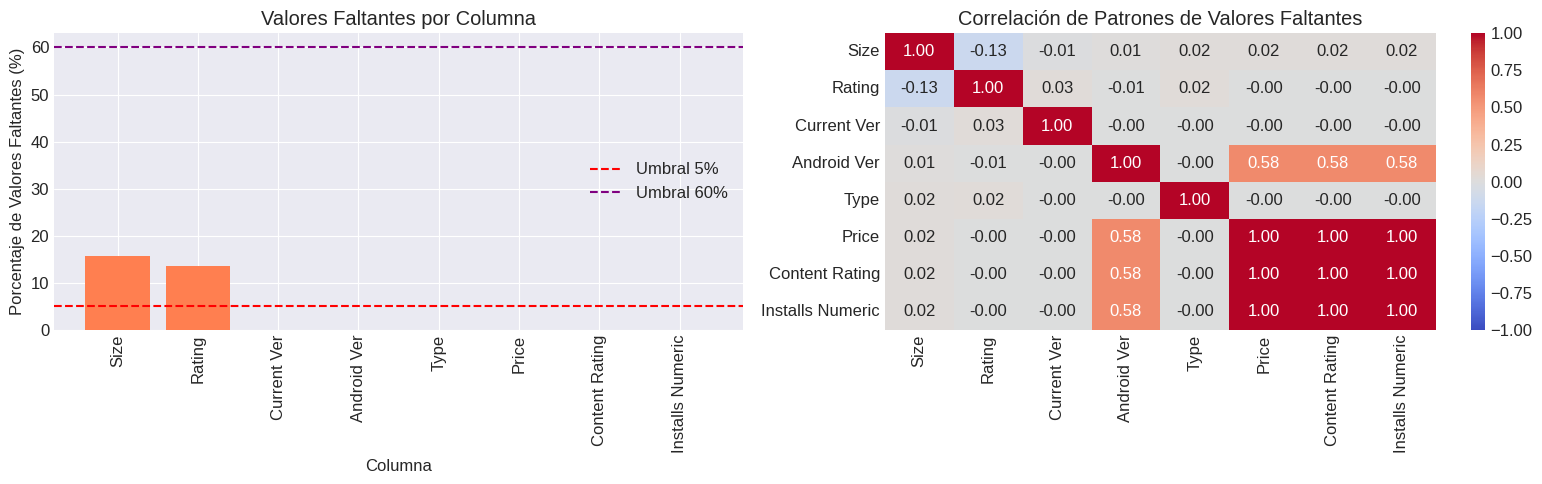

,Columna,Valores_Faltantes,Porcentaje,Tipo_Dato
4,Size,1696,15.64,float64
2,Rating,1474,13.60,float64
11,Current Ver,8,0.07,object
12,Android Ver,3,0.03,object
6,Type,1,0.01,object
7,Price,1,0.01,float64
8,Content Rating,1,0.01,object
13,Installs Numeric,1,0.01,float64


In [8]:
def analyze_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """Análisis completo de valores faltantes con visualizaciones."""
    missing_counts = df.isnull().sum()
    missing_pct = (missing_counts / len(df)) * 100

    missing_df = pd.DataFrame({
        'Columna': df.columns,
        'Valores_Faltantes': missing_counts.values,
        'Porcentaje': missing_pct.values,
        'Tipo_Dato': df.dtypes.values
    })

    missing_df = missing_df[missing_df['Valores_Faltantes'] > 0].sort_values('Porcentaje', ascending=False)

    if len(missing_df) == 0:
        print("No hay valores faltantes en el dataset")
        return missing_df

    # Visualización: barras y correlación de patrones de faltantes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    # Gráfico de barras de % faltantes
    ax1.bar(missing_df['Columna'], missing_df['Porcentaje'], color='coral')
    ax1.set_xlabel('Columna')
    ax1.set_ylabel('Porcentaje de Valores Faltantes (%)')
    ax1.set_title('Valores Faltantes por Columna')
    ax1.axhline(y=5, color='r', linestyle='--', label='Umbral 5%')
    ax1.axhline(y=60, color='purple', linestyle='--', label='Umbral 60%')
    ax1.tick_params(axis='x', rotation=90)
    ax1.legend()

    # Heatmap de correlación de patrones de faltantes
    mask_df = df[missing_df['Columna'].tolist()].isnull().astype(int)
    if mask_df.shape[1] >= 2:
        corr = mask_df.corr()
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, ax=ax2)
        ax2.set_title('Correlación de Patrones de Valores Faltantes')
    else:
        ax2.axis('off')
        ax2.set_title('Correlación de faltantes (no aplica: 1 columna)')

    plt.tight_layout()
    plt.show()

    return missing_df

missing_analysis = analyze_missing_values(applications_data)
if missing_analysis is not None and not missing_analysis.empty:
    display(missing_analysis)

### 2.2.6 Estadisticas descriptivas y univariadas (númerico)

A partir de la tabla de estadísticas y los gráficos generados para `Rating`, `Reviews`, `Size`, `Price` e `Installs Numeric`, se observan los siguientes puntos clave.

- Rating
  - Media ≈ 4.19 y mediana ≈ 4.30 → ligera cola a la izquierda (más apps con rating alto). Hay un valor imposible (≈19), confirmado en el boxplot/Q-Q como outlier extremo.
  - Outliers: ~5% por IQR, dominados por el valor inválido y algunos ratings bajos.
  - Q-Q plot: desviación frente a normalidad, esperable para una variable acotada [1,5].
  - Implicación/acción: eliminar filas sin `Rating` para modelado; corregir `Rating=19 → NaN` y excluir; no aplicar transformaciones (la escala es ya interpretables).

- Reviews
  - Media ≫ mediana (pico en 0–pocos miles; máximo ≈ 78M) → cola muy larga a la derecha.
  - Boxplot: ~18% outliers por IQR (muchas apps con reseñas muy altas).
  - Q-Q plot: gran desviación de normalidad (heavy tail).
  - Relación con Rating: correlación positiva muy débil (~0.07), tendencia casi plana.
  - Implicación/acción: usar `log1p(Reviews)` para estabilizar la distribución en análisis/modelado; considerar winsorizar p99.9 para vistas tabulares si se desea.

- Size (MB)
  - Media > mediana (≈ 21.5 vs 13) → sesgo a la derecha; valores hasta 100 MB.
  - ~6% outliers por IQR, especialmente en colas altas.
  - Q-Q plot: curvatura en colas; no normal.
  - Relación con Rating: correlación positiva débil (~0.08); señal muy tenue.
  - Implicación/acción: imputar faltantes por `Category × Type` y añadir `size_missing`; opcionalmente probar `log1p(Size)` o binning para robustecer.

- Price (USD)
  - Mediana = 0 (mayoría gratis) y cola a la derecha con máximos altos (≈ 400).
  - ~7% outliers por IQR; Q-Q muestra heavy tail.
  - Relación con Rating: correlación negativa muy débil (~-0.02).
  - Implicación/acción: crear `is_free = (Price == 0)` y, si se usa `Price` continuo, considerar `log1p(Price)` para las pocas apps pagas; validar coherencia `Type=Free ⇒ Price=0`.

- Installs Numeric
  - Media ≫ mediana (100k) con máximo 1e9 → distribución extremadamente sesgada a la derecha.
  - ~7–8% outliers por IQR; Q-Q muy alejado de normalidad.
  - Relación con Rating: correlación débil positiva (~0.05) y tendencia casi plana.
  - Implicación/acción: usar `log1p(Installs Numeric)` o bins ordinales para análisis; verificar coherencia con `Installs` textual.

Recomendaciones transversales
- Eliminar duplicados antes de resumir para evitar sesgos.
- Tratar outliers evidentes no-legítimos (p. ej. `Rating=19`). Para colas largas legítimas (`Reviews`, `Installs Numeric`, `Price`): preferir `log1p` o winsorización solo para visualizaciones.
- Mantener consistencia: `Type=Free ⇒ Price=0`; `Installs Numeric` coherente con el rango de `Installs`.
- Para relaciones con `Rating`, las correlaciones lineales observadas son débiles; la señal puede emerger mejor con interacciones (p. ej., `is_free × installs_bin`) o modelos no lineales.



,count,mean,std,min,25%,50%,75%,max,mad,skew,kurtosis,cv
Rating,9367.00,4.19,0.54,1.00,4.00,4.30,4.50,19.00,0.20,0.60,66.00,0.13
Reviews,10841.00,444111.93,2927628.66,0.00,38.00,2094.00,54768.00,78158306.00,2094.00,16.45,341.09,6.59
Size,9145.00,21.52,22.59,0.01,4.90,13.00,30.00,100.00,9.70,1.56,1.92,1.05
Price,10840.00,1.03,15.95,0.00,0.00,0.00,0.00,400.00,0.00,23.71,578.14,15.53
Installs Numeric,10840.00,15464338.88,85029361.39,0.00,1000.00,100000.00,5000000.00,1000000000.00,99990.00,9.57,100.28,5.50


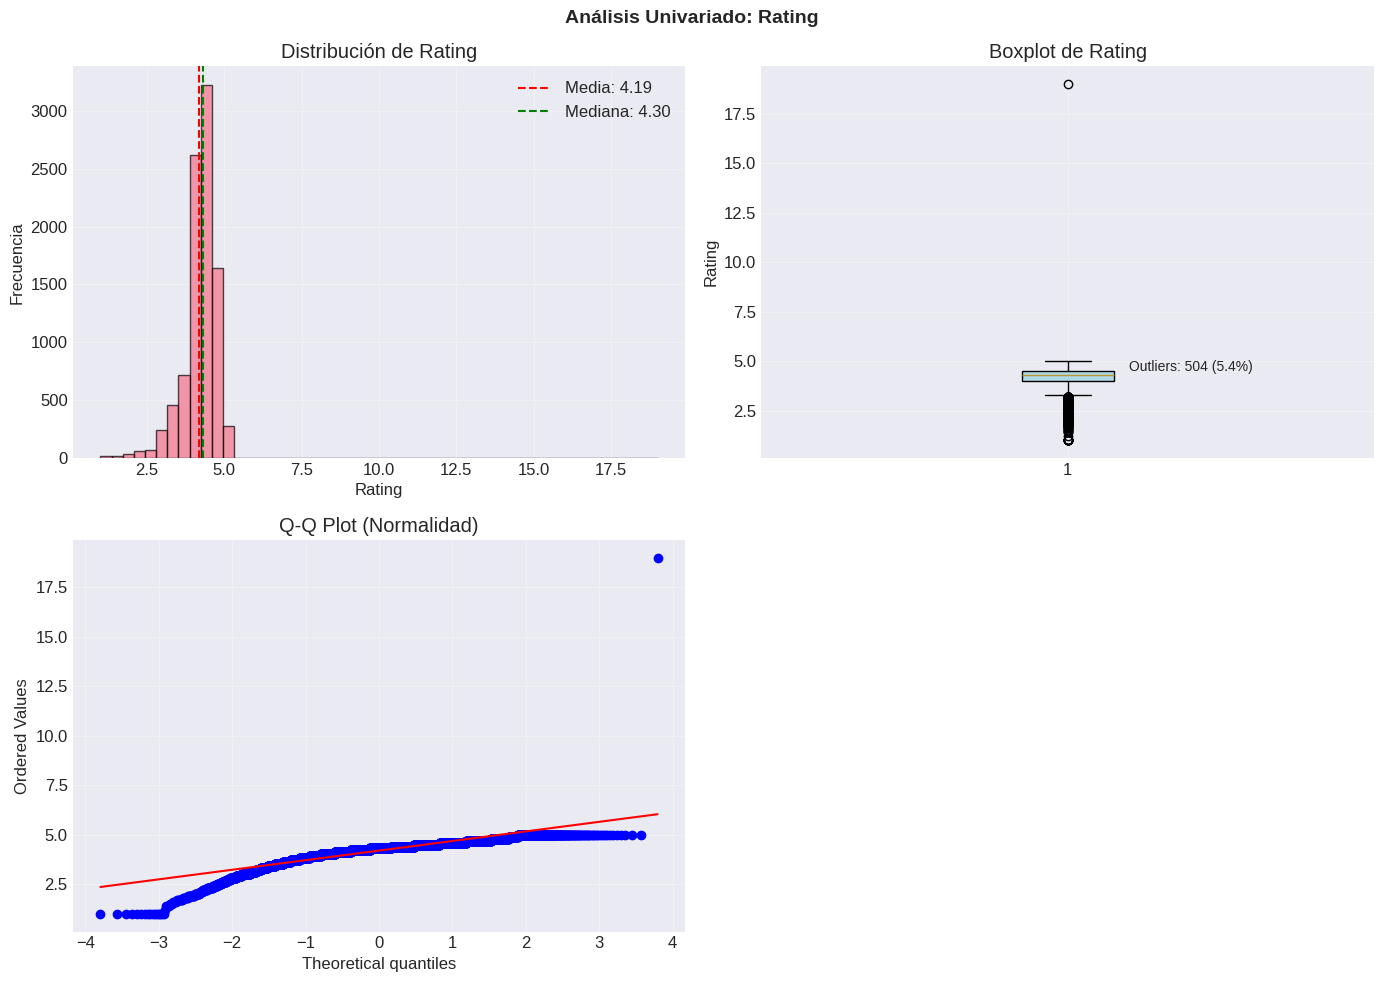

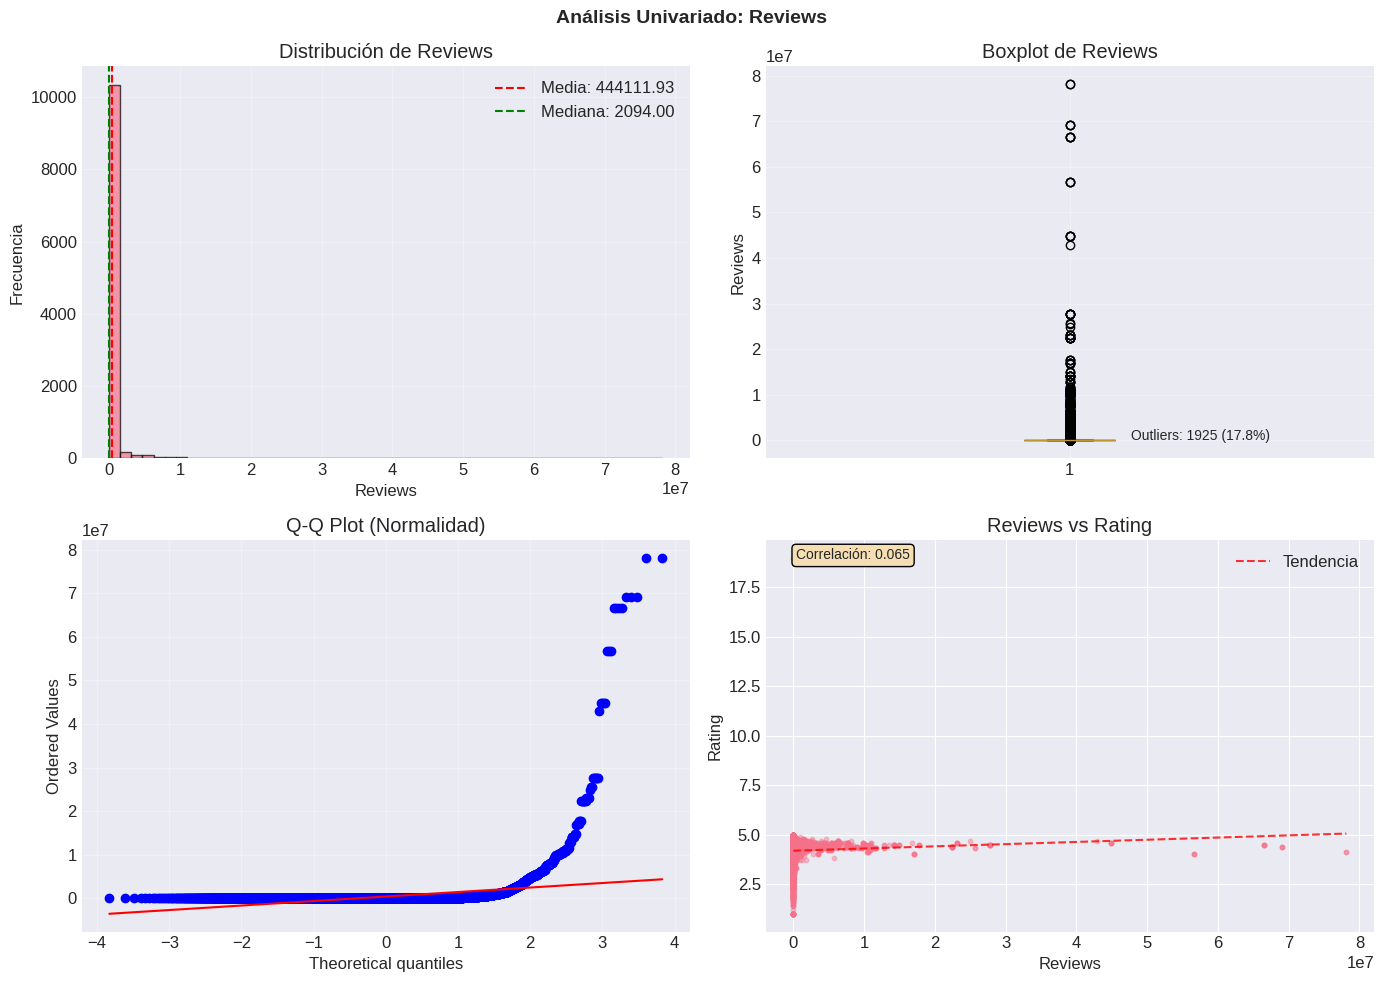

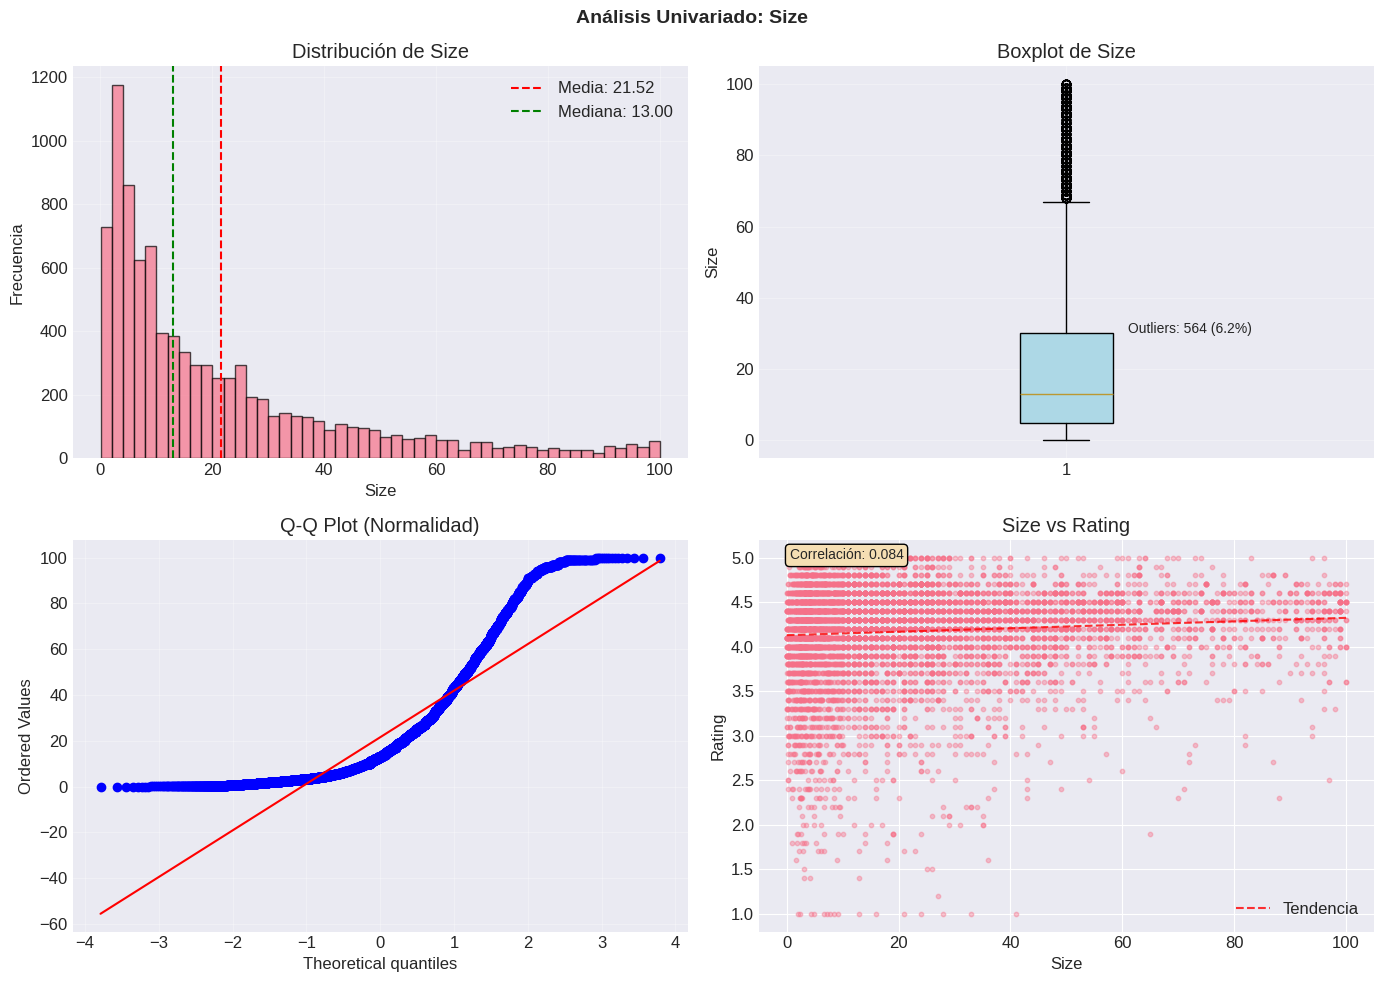

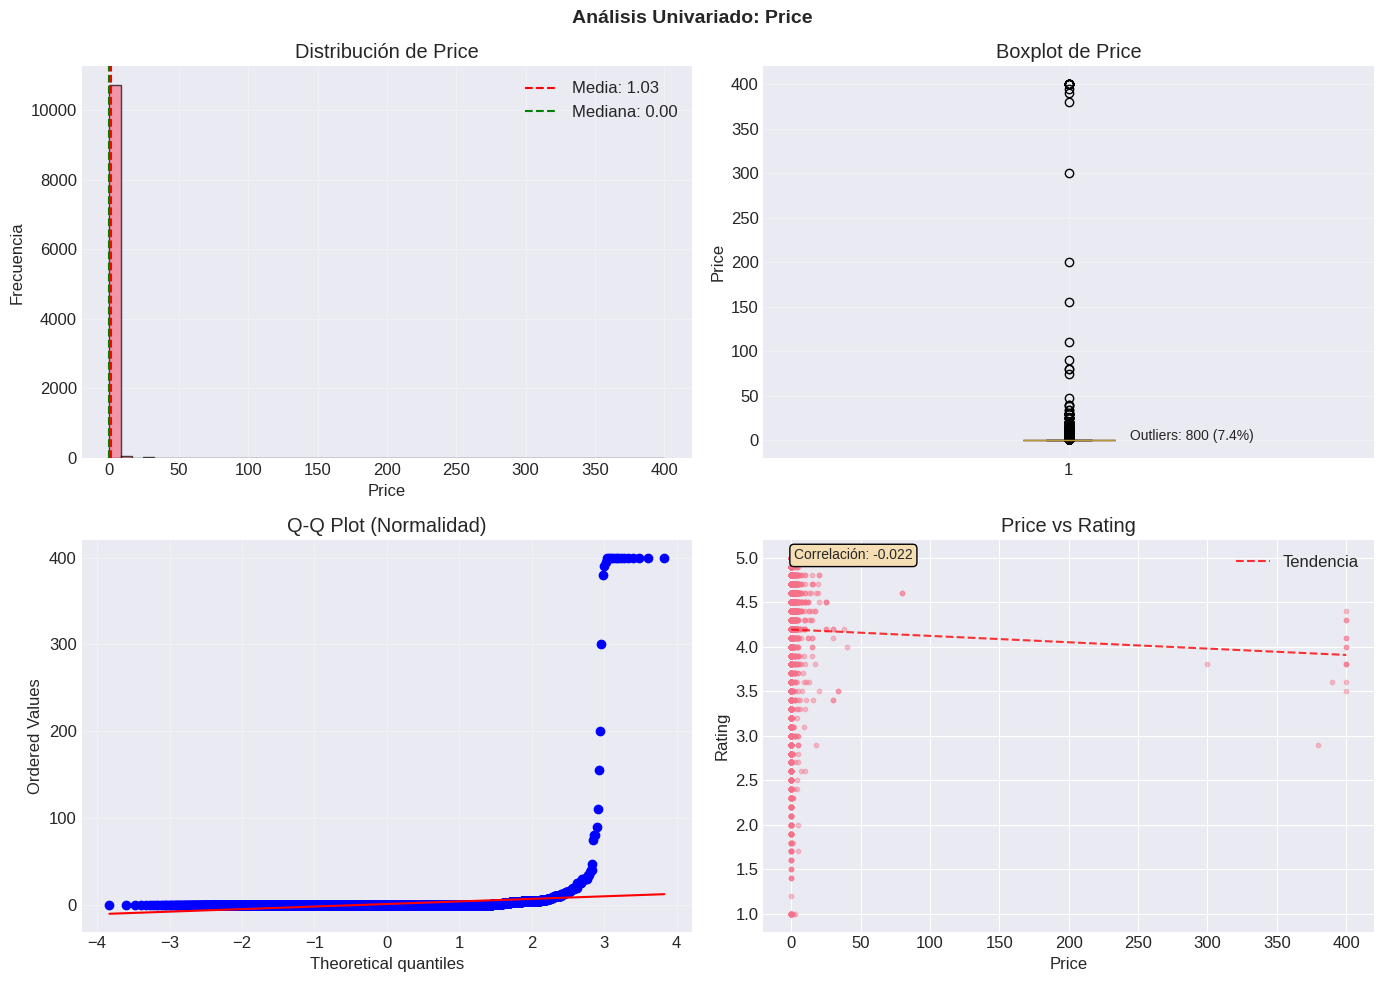

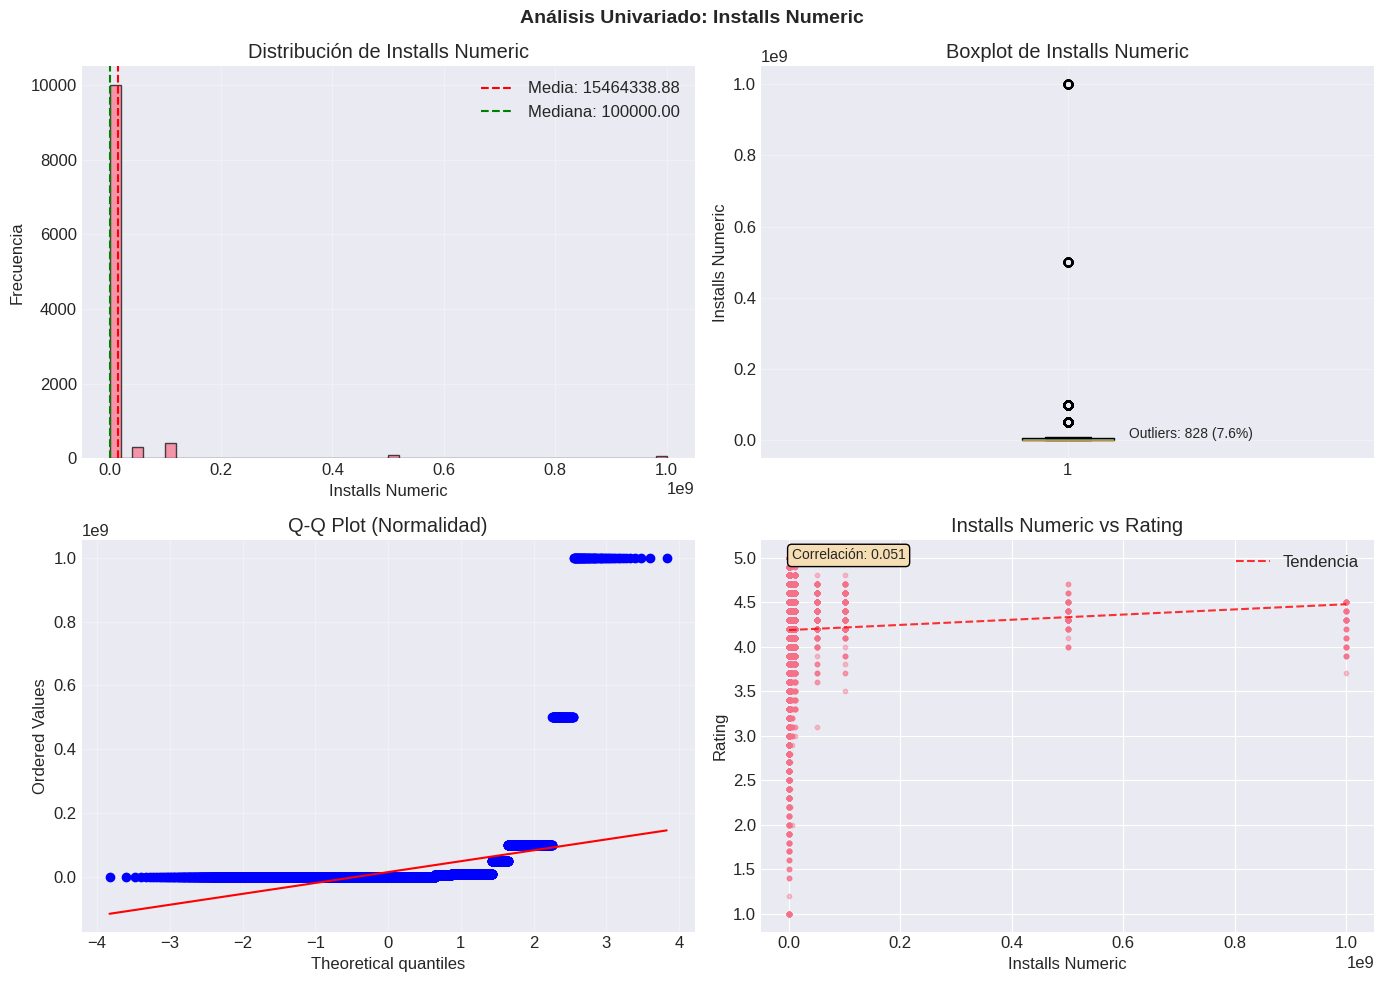

In [9]:
from scipy import stats

# Selección de columnas numéricas relevantes
numeric_cols = [c for c in ['Rating', 'Reviews', 'Size', 'Price', 'Installs Numeric'] if c in applications_data.columns]

# Tabla de estadísticas básicas (media, mediana, std, min, p25, p50, p75, max)
describe_tbl = applications_data[numeric_cols].describe(percentiles=[0.25, 0.5, 0.75]).T

# Métricas adicionales robustas
extra = pd.DataFrame(index=numeric_cols)
extra['mad'] = [stats.median_abs_deviation(applications_data[c].dropna()) for c in numeric_cols]
extra['skew'] = [applications_data[c].skew(skipna=True) for c in numeric_cols]
extra['kurtosis'] = [applications_data[c].kurtosis(skipna=True) for c in numeric_cols]
extra['cv'] = [applications_data[c].std(skipna=True) / applications_data[c].mean(skipna=True) if applications_data[c].mean(skipna=True) not in [0, np.nan] else np.nan for c in numeric_cols]

stats_table = describe_tbl.join(extra)
display(stats_table.round(3))


def univariate_analysis(df: pd.DataFrame, column: str, target: str | None = None):
    """Análisis univariado con histograma, boxplot, Q-Q plot y relación con target."""
    series = df[column].dropna()
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1) Histograma con líneas de media y mediana
    ax1 = axes[0, 0]
    ax1.hist(series, bins=50, edgecolor='black', alpha=0.7)
    ax1.axvline(series.mean(), color='red', linestyle='--', label=f"Media: {series.mean():.2f}")
    ax1.axvline(series.median(), color='green', linestyle='--', label=f"Mediana: {series.median():.2f}")
    ax1.set_title(f"Distribución de {column}")
    ax1.set_xlabel(column)
    ax1.set_ylabel('Frecuencia')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # 2) Boxplot + conteo de outliers (IQR)
    ax2 = axes[0, 1]
    bp = ax2.boxplot(series, vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    Q1, Q3 = series.quantile(0.25), series.quantile(0.75)
    IQR = Q3 - Q1
    outliers_mask = (series < Q1 - 1.5 * IQR) | (series > Q3 + 1.5 * IQR)
    n_out = int(outliers_mask.sum())
    pct_out = 100 * n_out / len(series) if len(series) else 0
    ax2.set_title(f"Boxplot de {column}")
    ax2.set_ylabel(column)
    ax2.grid(alpha=0.3)
    ax2.text(1.1, Q3, f"Outliers: {n_out} ({pct_out:.1f}%)", fontsize=10)

    # 3) Q-Q plot normal
    ax3 = axes[1, 0]
    stats.probplot(series, dist='norm', plot=ax3)
    ax3.set_title('Q-Q Plot (Normalidad)')
    ax3.grid(alpha=0.3)

    # 4) Relación con target si aplica
    ax4 = axes[1, 1]
    if target is not None and target in df.columns and column != target:
        valid = df[[column, target]].dropna()
        ax4.scatter(valid[column], valid[target], alpha=0.4, s=10)
        ax4.set_xlabel(column)
        ax4.set_ylabel(target)
        ax4.set_title(f"{column} vs {target}")
        # Línea de tendencia (ajuste lineal simple)
        if len(valid) > 1:
            z = np.polyfit(valid[column], valid[target], 1)
            p = np.poly1d(z)
            xs = np.linspace(valid[column].min(), valid[column].max(), 200)
            ax4.plot(xs, p(xs), 'r--', alpha=0.8, label='Tendencia')
            corr = valid[column].corr(valid[target])
            ax4.text(0.05, 0.95, f"Correlación: {corr:.3f}", transform=ax4.transAxes,
                     fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat'))
            ax4.legend()
    else:
        ax4.axis('off')
        ax4.grid(alpha=0.3)

    plt.suptitle(f"Análisis Univariado: {column}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Ejecutar análisis univariado para cada métrica numérica, relacionando con Rating
for col in numeric_cols:
    univariate_analysis(applications_data, col, target='Rating')

### 2.2.7. Análisis Univariado Categórico
- Category
  - Distribución: alta concentración en `FAMILY` (~19%) y `GAME` (~12%). El resto de categorías tienen menor peso individual; el grupo `Others` acumula ~31% del total.
  - Rating por categoría: diferencias moderadas; la **mediana** suele estar entre 4.2–4.4. Algunas categorías muestran desviación estándar mayor (p. ej., `PRODUCTIVITY`, `LIFESTYLE`), indicando más variabilidad de valoración.
  - Implicaciones: riesgo de sesgo por categorías mayoritarias en análisis agregados. Para modelado, conviene usar dummies Top-K o codificación ordinal/target encoding con cuidado (evitar fuga). Agrupar colas largas en `Others` es adecuado para visualización.

- Content Rating
  - Distribución: `Everyone` domina (~79%), seguido por `Teen` (~12%); `Mature 17+` y `Everyone 10+` suman ~9% en conjunto; clases raras casi nulas.
  - Rating por nivel de contenido: medias similares (≈4.1–4.3). `Teen` tiende a mediana 4.3 y variabilidad algo menor; `Mature 17+` muestra algo más de dispersión.
  - Implicaciones: por el fuerte desbalance, esta variable aporta señal limitada por sí sola. Útil como interacción con `Category`/`Genres`.

- Type
  - Distribución: `Free` ≈ 93%, `Paid` ≈ 7% (clase muy desbalanceada); existe un registro anómalo (valor 0) en los gráficos que debe eliminarse/corregirse.
  - Rating por tipo: medias muy cercanas (Free ≈ 4.19, Paid ≈ 4.27). La diferencia es pequeña y probablemente no significativa sin controlar otras variables (p. ej., `Category`).
  - Implicaciones: por el desbalance extremo, conviene usar `is_free` como binaria y, si se modela interacción con `Installs` o `Price`, puede emerger señal. Validar regla `Type=Free ⇒ Price=0`.

- Genres Main (primer género)
  - Distribución: gran cola larga; `Others` concentra ~48%. Entre Top-12, `Tools`, `Entertainment` y `Education` destacan en frecuencia.
  - Rating por género: diferencias pequeñas (medianas ~4.2–4.4), con algunas variaciones en dispersión (p. ej., `Medical` y `Lifestyle` más variables).
  - Implicaciones: por la alta cardinalidad y colas largas, mantener Top-K + `Others` en EDA ayuda a la legibilidad. Para modelado, preferir codificación que reduzca dimensionalidad (Top-K dummies, hashing, o target encoding con validación adecuada).

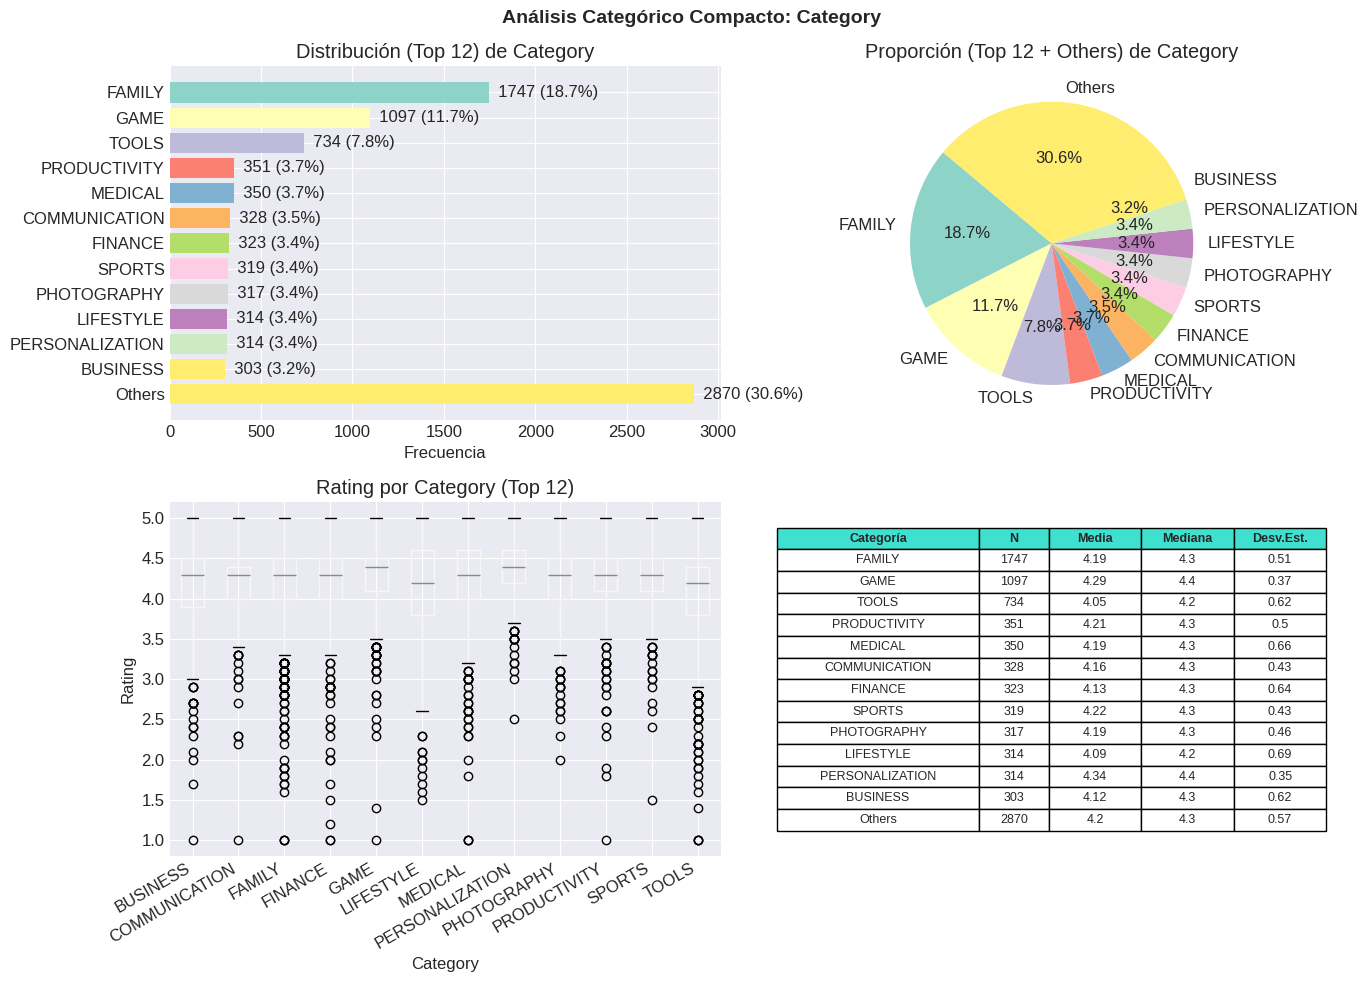

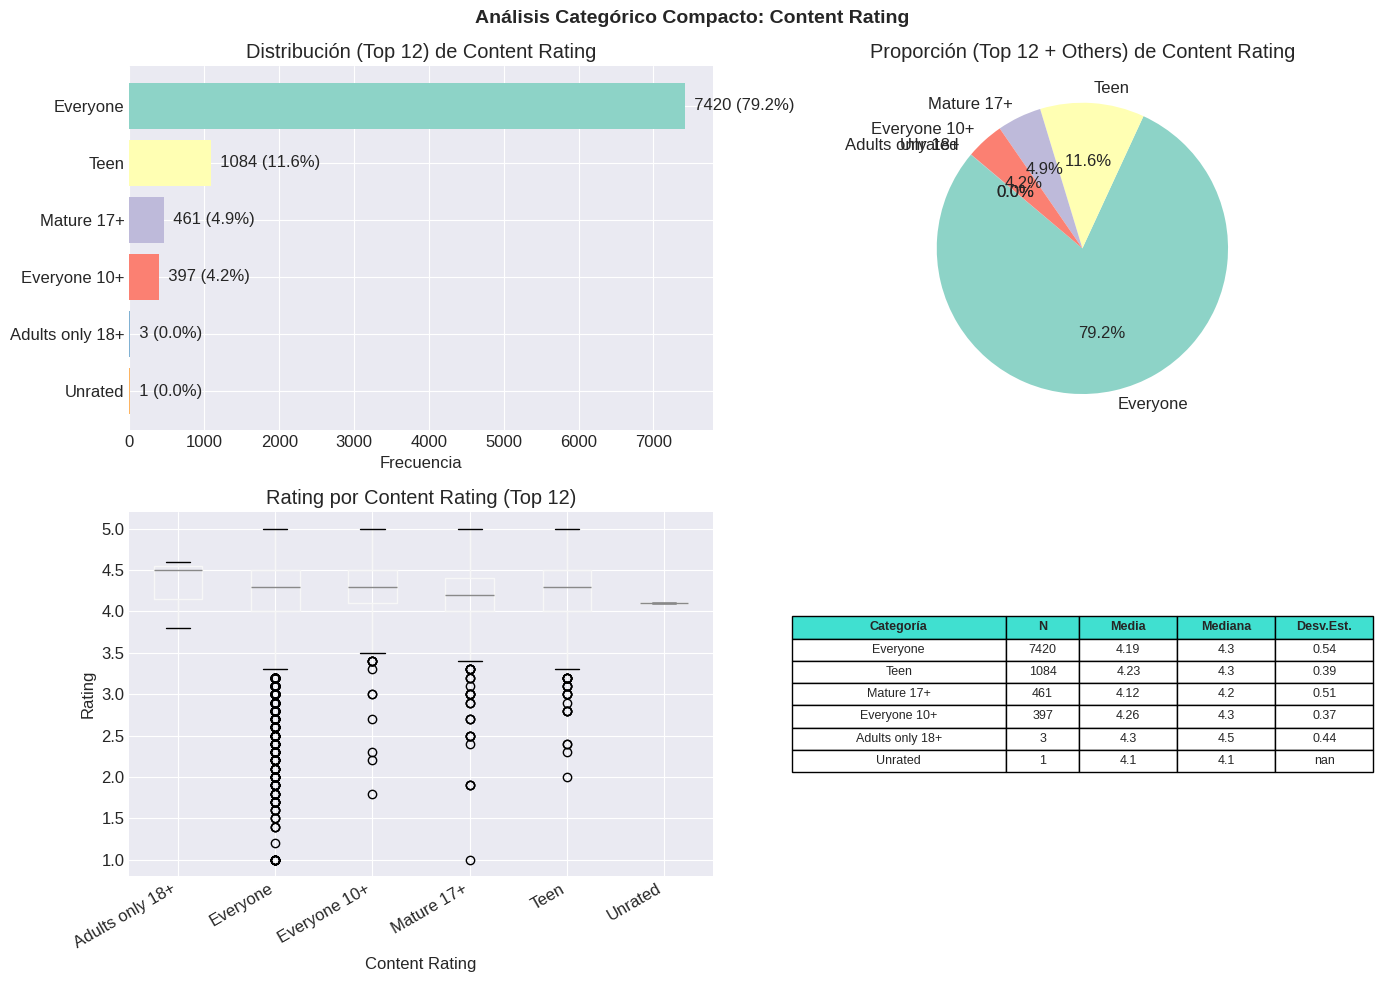

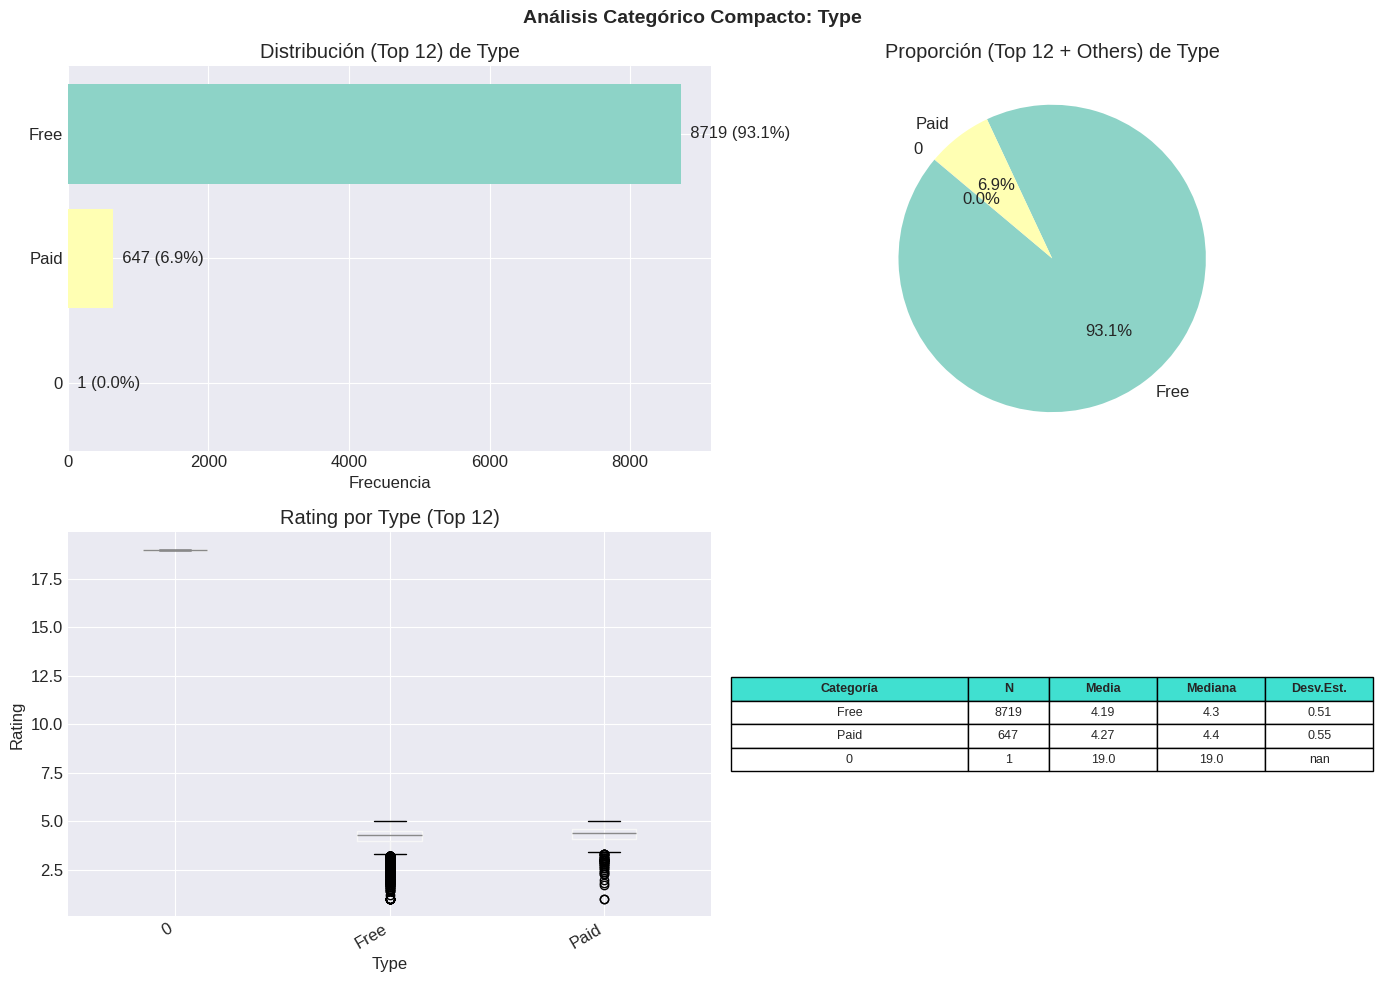

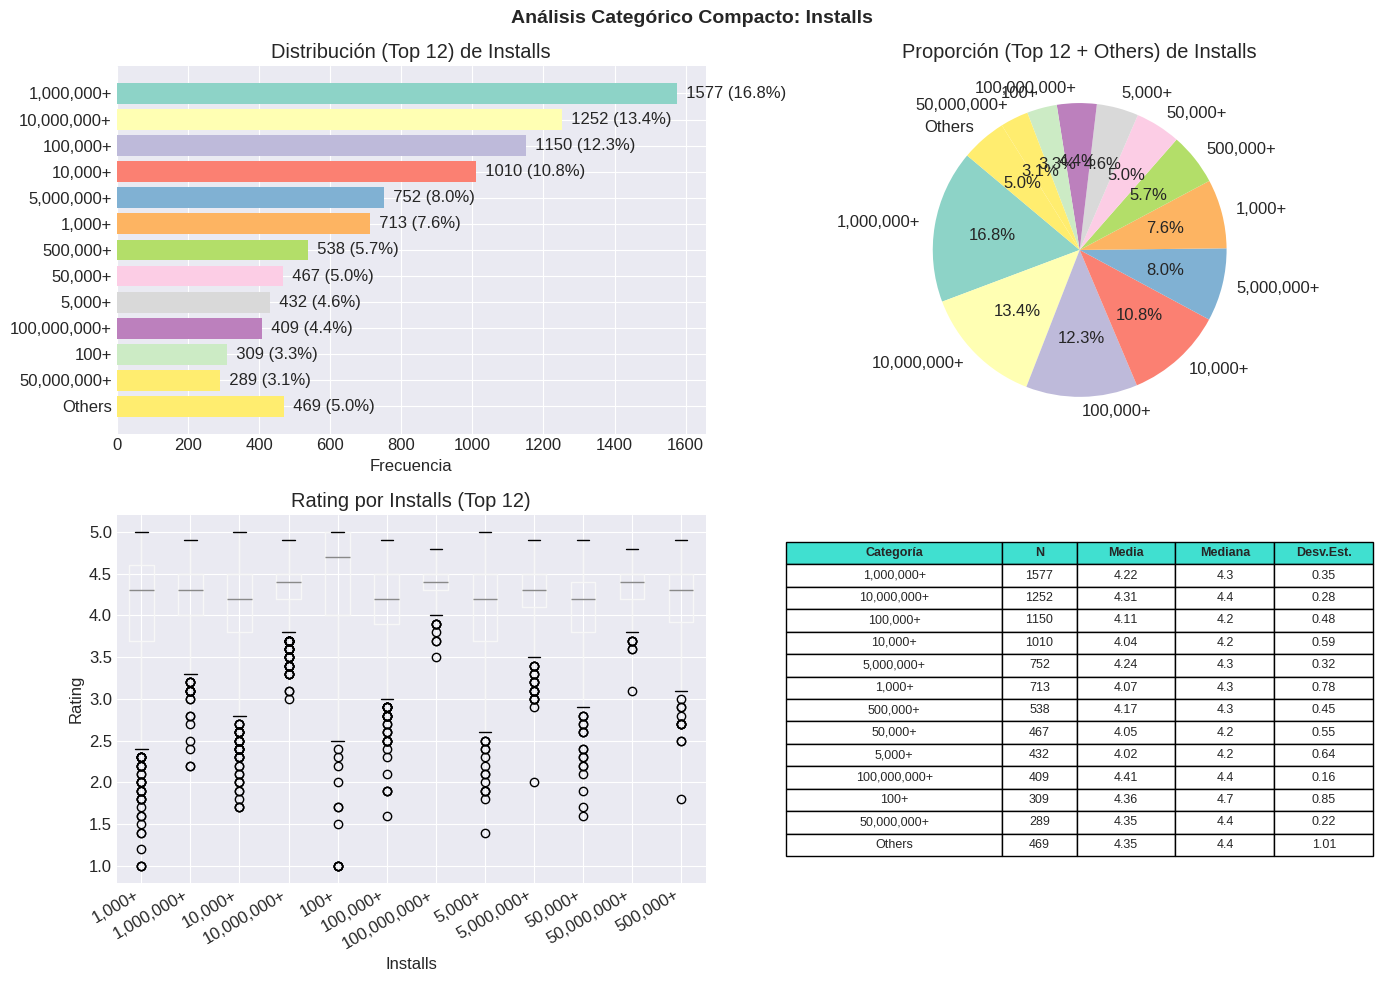

In [10]:
def analyze_categorical_compact(df: pd.DataFrame, cat_col: str, target_col: str, top_n: int = 12):
    """
    Versión compacta para variables con muchas categorías:
    - Ordena por frecuencia, muestra top_n y agrupa el resto en "Others".
    - Barras horizontales, pie chart compacto, boxplot y tabla para top_n.
    """
    data = df[[cat_col, target_col]].dropna(subset=[cat_col, target_col]).copy()
    if data.empty:
        print(f"Sin datos para {cat_col} y {target_col}")
        return

    counts = data[cat_col].value_counts()
    top_cats = counts.head(top_n)
    others_count = counts.iloc[top_n:].sum()

    # Mapeo a top_n + Others
    mapping = {c: c for c in top_cats.index}
    data['__cat__'] = data[cat_col].where(data[cat_col].isin(top_cats.index), other='Others')

    # Recalcular conteos con Others
    counts_compact = data['__cat__'].value_counts()
    order = list(top_cats.index) + (['Others'] if 'Others' in counts_compact.index else [])

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1) Barras horizontales (mejor legibilidad)
    ax1 = axes[0, 0]
    vals = counts_compact.loc[order]
    ax1.barh(range(len(vals)), vals.values, color=plt.cm.Set3(range(len(vals))))
    ax1.set_yticks(range(len(vals)))
    ax1.set_yticklabels(order)
    ax1.invert_yaxis()
    ax1.set_title(f'Distribución (Top {top_n}) de {cat_col}')
    ax1.set_xlabel('Frecuencia')
    for i, v in enumerate(vals.values):
        ax1.text(v, i, f'  {v} ({v/len(data)*100:.1f}%)', va='center')

    # 2) Pie chart compacto
    ax2 = axes[0, 1]
    ax2.pie(vals.values, labels=order, autopct='%1.1f%%', startangle=140,
            colors=plt.cm.Set3(range(len(vals))))
    ax2.set_title(f'Proporción (Top {top_n} + Others) de {cat_col}')

    # 3) Boxplot del target por categoría (solo top_n)
    ax3 = axes[1, 0]
    top_mask = data['__cat__'] != 'Others'
    data_top = data[top_mask]
    data_top.boxplot(column=target_col, by='__cat__', ax=ax3)
    ax3.set_title(f'{target_col} por {cat_col} (Top {top_n})')
    ax3.set_xlabel(cat_col)
    ax3.set_ylabel(target_col)
    plt.sca(ax3)
    plt.xticks(rotation=30, ha='right')

    # 4) Tabla de estadísticas por categoría (solo top_n y Others si existe)
    ax4 = axes[1, 1]
    ax4.axis('off')
    stats_by_cat = data.groupby('__cat__')[target_col].agg(['count', 'mean', 'median', 'std']).loc[order].round(2)
    table = ax4.table(cellText=stats_by_cat.reset_index().values,
                      colLabels=['Categoría', 'N', 'Media', 'Mediana', 'Desv.Est.'],
                      cellLoc='center', loc='center', colWidths=[0.35, 0.12, 0.16, 0.16, 0.16])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.05, 1.25)
    for i in range(5):
        table[(0, i)].set_facecolor('#40E0D0')
        table[(0, i)].set_text_props(weight='bold')

    plt.suptitle(f'Análisis Categórico Compacto: {cat_col}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Ejecutar la versión compacta para las categóricas clave
for cat in [c for c in ['Category', 'Content Rating', 'Type', 'Genres Main', 'Installs'] if c in applications_data.columns]:
    analyze_categorical_compact(applications_data, cat, 'Rating', top_n=12)

### 2.2.8. Análisis de correlación entre variables

#### 2.2.8.1. Variables con Mayor Relación
- Existe una fuerte correlación positiva entre **Installs Numeric** y **Reviews**:
  - Pearson: 0.64 (relación lineal moderada-fuerte).
  - Spearman: 0.97 (relación monótonica muy fuerte).
- Esto implica que a mayor número de instalaciones, mayor número de reseñas.

#### 2.2.8.2. Correlación de Pearson
- En general, las correlaciones de Pearson muestran relaciones más débiles que Spearman, lo cual indica que las relaciones lineales no son tan marcadas.
- **Installs Numeric y Reviews** presentan la correlación lineal más alta (0.64), siendo moderada-fuerte.
- **Size y Reviews** muestran una correlación positiva baja/Débil (0.24).
- El resto de variables (Rating, Price) tienen correlaciones casi nulas con las demás, lo que refleja poca relación lineal.

#### 2.2.8.3. Correlación de Spearman
- **Installs Numeric y Reviews** tienen la correlación más fuerte (0.97).
- **Size** muestra correlación moderada con **Reviews** (0.37) y con **Installs Numeric** (0.35).
- **Price** presenta correlaciones negativas con **Reviews** (-0.17) e **Installs Numeric** (-0.24).

#### 2.2.8.4. Observaciones Clave
- El número de instalaciones y las reseñas son las variables más relacionadas, lo cual es lógico, ya que más usuarios generan más interacciones.
- El tamaño de la aplicación influye ligeramente en reseñas e instalaciones, pero no de forma determinante.
- El precio no solo carece de relación positiva, sino que parece tener un impacto negativo sobre la popularidad (menos instalaciones y reseñas).

#### 2.2.8.5. Conclusión
- **Installs Numeric** y **Reviews** son las métricas más críticas en el dataset de **Google Play Store**, ya que reflejan el éxito y la popularidad de la aplicación.
- **Size** es un factor secundario con cierta relación.

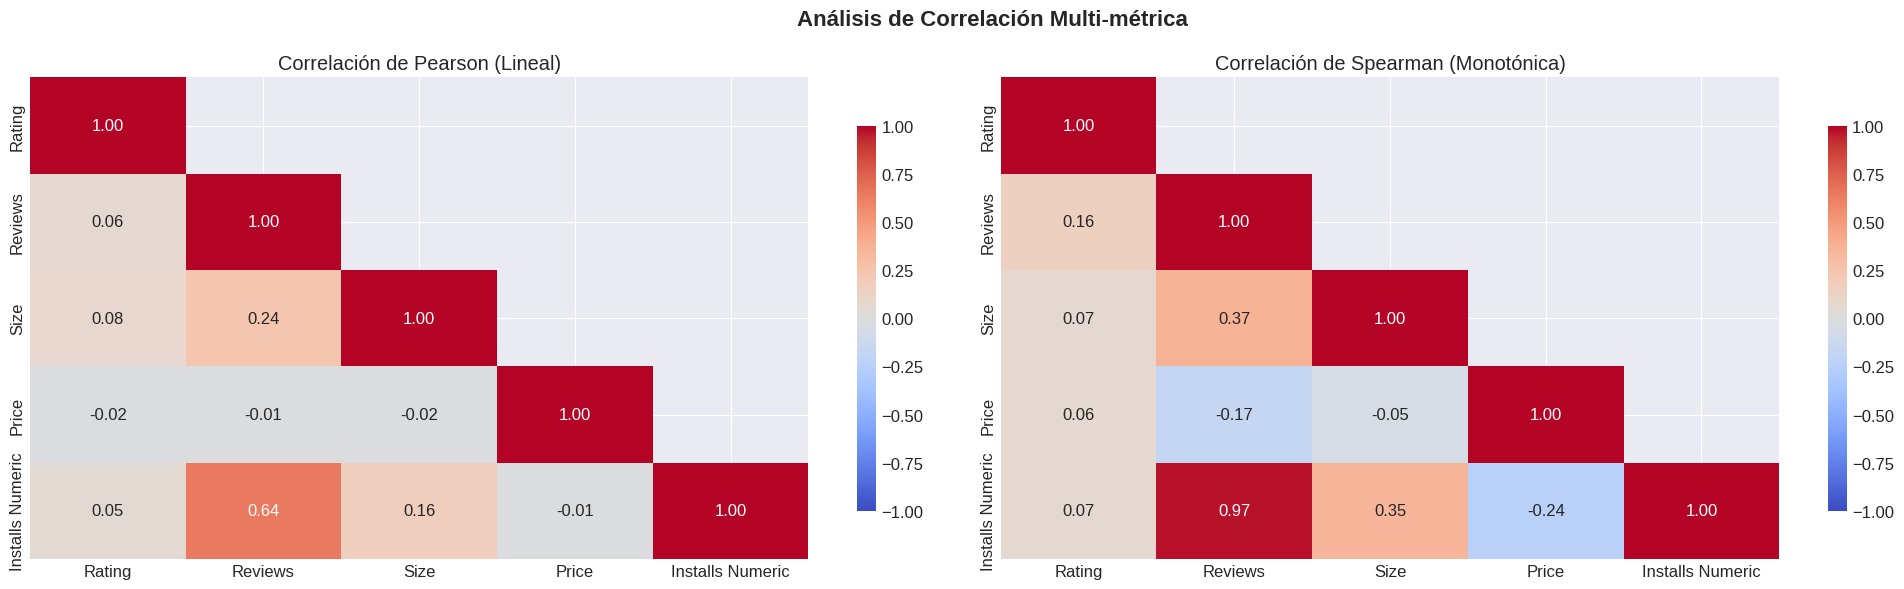


🔗 Correlaciones Significativas:

Pearson:
  • Reviews y Installs Numeric: +0.643 (Fuerte Positiva)
  • Installs Numeric y Reviews: +0.643 (Fuerte Positiva)

Spearman:
  • Reviews y Size: +0.367 (Moderada Positiva)
  • Reviews y Installs Numeric: +0.971 (Fuerte Positiva)
  • Size y Reviews: +0.367 (Moderada Positiva)
  • Size y Installs Numeric: +0.348 (Moderada Positiva)
  • Installs Numeric y Reviews: +0.971 (Fuerte Positiva)
  • Installs Numeric y Size: +0.348 (Moderada Positiva)


In [11]:
# Análisis de correlación mejorado para el proyecto de Google Play Store
def correlation_analysis(df):
    """Análisis de correlación con múltiples métricas"""
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    # 1. Correlación de Pearson
    corr_pearson = df[numeric_cols].corr(method='pearson')
    mask = np.triu(np.ones_like(corr_pearson), k=1)
    sns.heatmap(corr_pearson, mask=mask, annot=True, fmt='.2f', 
               cmap='coolwarm', center=0, ax=axes[0],
               vmin=-1, vmax=1, cbar_kws={"shrink": 0.8})
    axes[0].set_title('Correlación de Pearson (Lineal)')
    
    # 2. Correlación de Spearman  
    corr_spearman = df[numeric_cols].corr(method='spearman')
    sns.heatmap(corr_spearman, mask=mask, annot=True, fmt='.2f',
               cmap='coolwarm', center=0, ax=axes[1],
               vmin=-1, vmax=1, cbar_kws={"shrink": 0.8})
    axes[1].set_title('Correlación de Spearman (Monotónica)')
    
    plt.suptitle('Análisis de Correlación Multi-métrica', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Tabla de correlaciones importantes
    print("\n🔗 Correlaciones Significativas:")
    print("=" * 50)
    for method, corr_matrix in zip(['Pearson', 'Spearman'], [corr_pearson, corr_spearman]):
        print(f"\n{method}:")
        significant_corr = corr_matrix[(abs(corr_matrix) > 0.3) & (corr_matrix != 1)].stack()
        for (var1, var2), corr in significant_corr.items():
            strength = "Fuerte" if abs(corr) > 0.5 else "Moderada" if abs(corr) > 0.3 else "Débil"
            direction = "Positiva" if corr > 0 else "Negativa"
            print(f"  • {var1} y {var2}: {corr:+.3f} ({strength} {direction})")
    
# Ejecutar el análisis de correlación
correlation_analysis(applications_data)

#### 2.2.9. Análisis de Outliers (IQR, Z-Score e Isolation Forest)
**Resumen cuantitativo**
- Total de registros analizados: **10,841**.
- Filas marcadas como outlier por método:
  - IQR: **3,489** filas (32.18%) → refleja colas largas especialmente en `Reviews`, `Installs Numeric`, `Price`.
  - Z-Score (> |3|): **654** filas (6.03%) → mucho más selectivo, captura extremos verdaderamente alejados tras estandarización.
  - Isolation Forest (contaminación=10%): **1,084** filas (10.0%) → patrón no lineal de anomalías combinadas.
- Consenso entre métodos:
  - Detectadas por los 3 métodos: **502** filas (casos altamente anómalos).
  - Detectadas exactamente por 2 métodos: **731** filas (anómalas consistentes, revisar antes de decidir acción).

**Variables más afectadas (IQR)**
- `Reviews`: **1,925** outliers → distribución extremadamente sesgada; valores muy altos representan apps masivas (probablemente legítimos).
- `Installs Numeric`: **828** outliers → escalas de descargas masivas (1e7–1e9).
- `Price`: **800** outliers → pocos productos de precio elevado (≥ p75 + 1.5·IQR); revisar si son apps premium legítimas.
- `Size`: **564** outliers → tamaños extremos (muy grandes o inusualmente pequeños).
- `Rating`: **504** outliers → incluye valores extremos bajos y el caso inválido (`Rating=19`).

**Interpretación y criterios**
- Muchos outliers provienen de fenómenos de cola larga típicos (popularidad extrema o modelo freemium/premium).
- No se recomienda eliminar masivamente outliers de `Reviews` o `Installs Numeric` sin antes transformar (`log1p`) o agrupar (binning), para no perder información sobre apps exitosas.
- El valor inválido `Rating` debe eliminars. Otros ratings muy bajos pueden mantenerse (aportan contraste) (perfecto si se encuentran entre 1 y 5).
- Outliers en `Price` podrían segmentarse: gratis (0), bajo costo (0 < p ≤ 10), premium (10 < p ≤ 50), ultra premium (>50).


**Conclusión**
El comportamiento extremo de `Reviews` e `Installs Numeric` refleja la naturaleza desigual del mercado (unas pocas apps concentran gran parte de la atención). Un manejo cuidadoso (transformaciones y flags) preservará información útil sin distorsionar el entrenamiento. Se prioriza limpieza puntual (ratings inválidos) sobre eliminación agresiva de outliers.

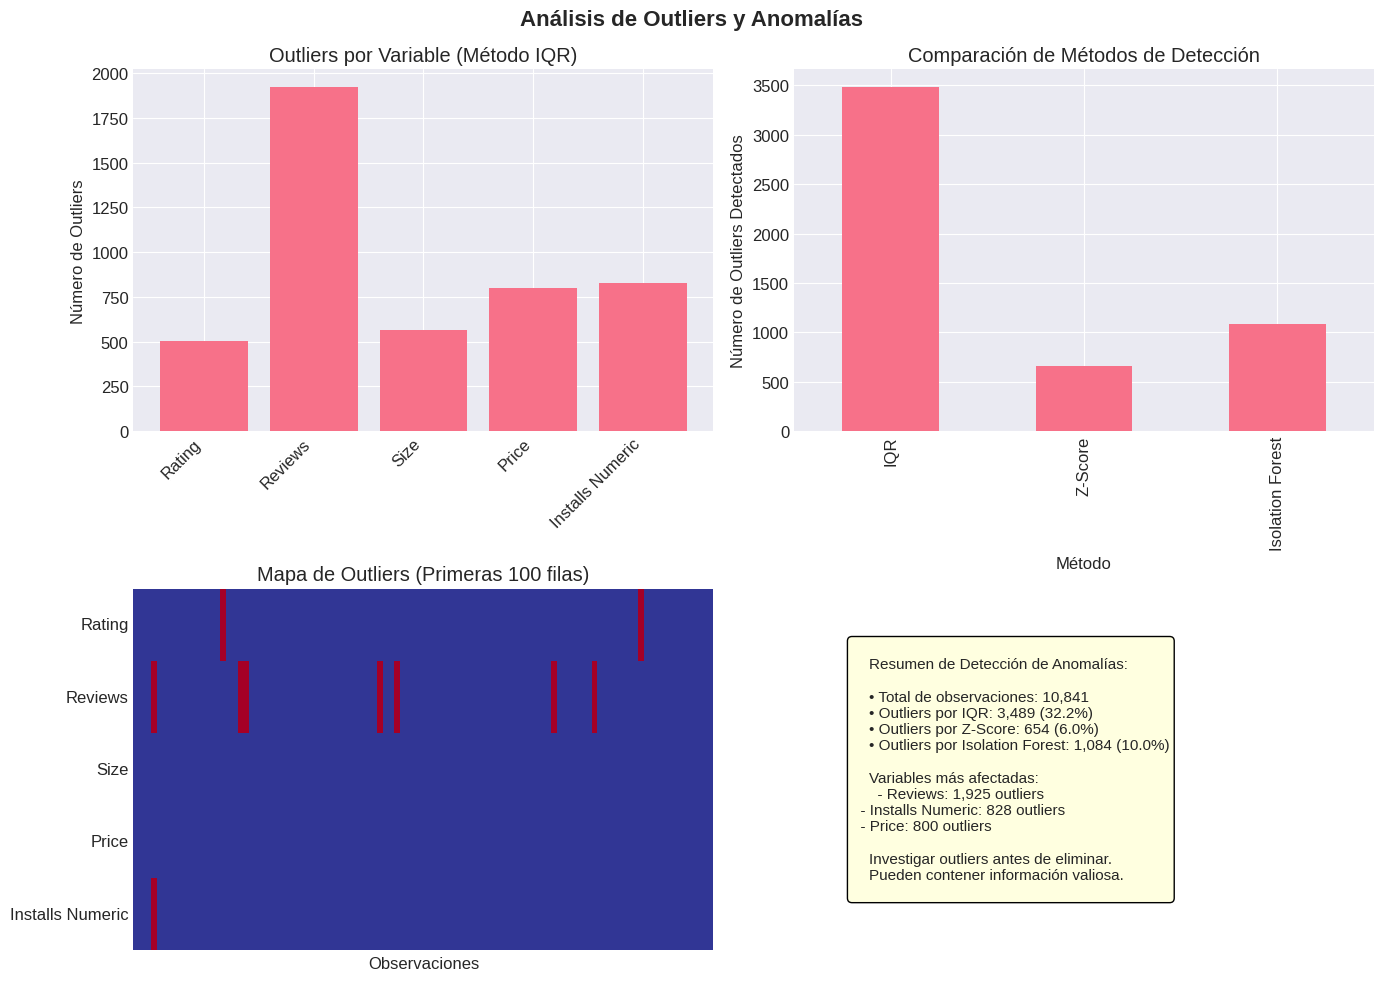

In [12]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

def detect_outliers(df):
    """Detección de outliers usando múltiples métodos"""
    
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Método 1: IQR
    outliers_iqr = pd.DataFrame()
    for col in numeric_df.columns:
        Q1 = numeric_df[col].quantile(0.25)
        Q3 = numeric_df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((numeric_df[col] < Q1 - 1.5 * IQR) | 
                   (numeric_df[col] > Q3 + 1.5 * IQR))
        outliers_iqr[col] = outliers
    
    # Método 2: Z-Score
    from scipy import stats
    z_scores = np.abs(stats.zscore(numeric_df.fillna(numeric_df.median())))
    outliers_zscore = (z_scores > 3)
    
    # Método 3: Isolation Forest
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_df.fillna(numeric_df.median()))
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    outliers_iso = iso_forest.fit_predict(scaled_data) == -1
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Outliers por columna (IQR)
    ax1 = axes[0, 0]
    outlier_counts = outliers_iqr.sum()
    ax1.bar(range(len(outlier_counts)), outlier_counts.values)
    ax1.set_xticks(range(len(outlier_counts)))
    ax1.set_xticklabels(outlier_counts.index, rotation=45, ha='right')
    ax1.set_title('Outliers por Variable (Método IQR)')
    ax1.set_ylabel('Número de Outliers')
    
    # Plot 2: Distribución de outliers por método
    ax2 = axes[0, 1]
    methods_comparison = pd.DataFrame({
        'IQR': outliers_iqr.any(axis=1).sum(),
        'Z-Score': outliers_zscore.any(axis=1).sum(),
        'Isolation Forest': outliers_iso.sum()
    }, index=['Outliers'])
    methods_comparison.T.plot(kind='bar', ax=ax2, legend=False)
    ax2.set_title('Comparación de Métodos de Detección')
    ax2.set_ylabel('Número de Outliers Detectados')
    ax2.set_xlabel('Método')
    
    # Plot 3: Heatmap de outliers
    ax3 = axes[1, 0]
    sample_outliers = outliers_iqr.head(100)
    sns.heatmap(sample_outliers.T, cmap='RdYlBu_r', cbar=False, ax=ax3,
               yticklabels=True, xticklabels=False)
    ax3.set_title('Mapa de Outliers (Primeras 100 filas)')
    ax3.set_xlabel('Observaciones')
    
    # Plot 4: Resumen estadístico
    ax4 = axes[1, 1]
    ax4.axis('off')
    summary_text = f"""
    Resumen de Detección de Anomalías:
    
    • Total de observaciones: {len(df):,}
    • Outliers por IQR: {outliers_iqr.any(axis=1).sum():,} ({outliers_iqr.any(axis=1).sum()/len(df)*100:.1f}%)
    • Outliers por Z-Score: {outliers_zscore.any(axis=1).sum():,} ({outliers_zscore.any(axis=1).sum()/len(df)*100:.1f}%)
    • Outliers por Isolation Forest: {outliers_iso.sum():,} ({outliers_iso.sum()/len(df)*100:.1f}%)
    
    Variables más afectadas:
    {chr(10).join([f'  - {col}: {count:,} outliers' 
                   for col, count in outlier_counts.nlargest(3).items()])}
    
    Investigar outliers antes de eliminar. 
    Pueden contener información valiosa.
    """
    ax4.text(0.1, 0.5, summary_text, transform=ax4.transAxes,
            fontsize=11, verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='lightyellow'))
    
    plt.suptitle('Análisis de Outliers y Anomalías', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return outliers_iqr, outliers_zscore, outliers_iso

# Ejecutar la detección de outliers en el dataset de aplicaciones
outliers_iqr, outliers_zscore, outliers_iso = detect_outliers(applications_data)

## 2.3. Preparación de los datos

Con base a todos los hallazgos del **Análisis Exploratorio de Datos (EDA)**, aplicaremos las siguientes técnicas de limpieza y transformación:

### 2.3.1. Resumen de problemas detectados

Durante el EDA identificamos:

1. **Duplicados**: 483 filas duplicadas (~4.46%)
2. **Valores imposibles**: Rating = 19 (fuera del rango 1-5)
3. **Valores faltantes**: 
   - Size ≈ 15.6%
   - Rating ≈ 13.6%
   - Current Ver, Android Ver, Content Rating, Type, Price (<1%)
4. **Outliers legítimos**: Distribuciones con colas largas en Reviews, Installs Numeric, Price, Size
5. **Variables con distribuciones sesgadas**: Requieren transformaciones logarítmicas
6. **Inconsistencias**: Necesidad de validar coherencia entre Type y Price

### 2.3.2. Plan de transformación

Aplicaremos las siguientes transformaciones en orden:

1. **Eliminación de duplicados**
2. **Corrección de valores imposibles**
3. **Imputación de valores faltantes** (estrategia por variable)
4. **Validación de consistencia** entre variables relacionadas
5. **Transformaciones de variables numéricas** (log, binning)
6. **Creación de variables derivadas** (features engineering básico)
7. **Resumen final** del dataset limpio


### 2.3.3. Eliminación de Duplicados

Eliminamos las **483 filas duplicadas** detectadas en el EDA para evitar:
- Sesgos en análisis estadísticos
- Sobrepeso de ciertas apps en el modelado
- Distorsión de métricas de evaluación


In [357]:
# Crear copia del dataset para transformaciones
df_clean = applications_data.copy()

print("=" * 80)
print("PASO 1: ELIMINACIÓN DE DUPLICADOS".center(80))
print("=" * 80)

# Estado inicial
print(f"\nRegistros antes de eliminar duplicados: {len(df_clean):,}")
print(f"Duplicados encontrados: {df_clean.duplicated().sum():,} ({df_clean.duplicated().sum()/len(df_clean)*100:.2f}%)")

# Mostrar algunos ejemplos de duplicados antes de eliminar
if df_clean.duplicated().sum() > 0:
    print("\nEjemplos de aplicaciones duplicadas:")
    duplicated_apps = df_clean[df_clean.duplicated(keep=False)].sort_values('App')
    display(duplicated_apps[['App', 'Category', 'Rating', 'Reviews', 'Installs']].head(10))

# Eliminar duplicados (manteniendo la primera ocurrencia)
df_clean = df_clean.drop_duplicates(keep='first')

# Estado final
print(f"\nRegistros después de eliminar duplicados: {len(df_clean):,}")
print(f"Filas eliminadas: {len(applications_data) - len(df_clean):,}")
print(f"Reducción: {((len(applications_data) - len(df_clean))/len(applications_data)*100):.2f}%")


                       PASO 1: ELIMINACIÓN DE DUPLICADOS                        

Registros antes de eliminar duplicados: 10,841
Duplicados encontrados: 483 (4.46%)

Ejemplos de aplicaciones duplicadas:


,App,Category,Rating,Reviews,Installs
1393,10 Best Foods for You,HEALTH_AND_FITNESS,4.00,2490.00,"500,000+"
1407,10 Best Foods for You,HEALTH_AND_FITNESS,4.00,2490.00,"500,000+"
2543,1800 Contacts - Lens Store,MEDICAL,4.70,23160.00,"1,000,000+"
2322,1800 Contacts - Lens Store,MEDICAL,4.70,23160.00,"1,000,000+"
2256,2017 EMRA Antibiotic Guide,MEDICAL,4.40,12.00,"1,000+"
2385,2017 EMRA Antibiotic Guide,MEDICAL,4.40,12.00,"1,000+"
1434,21-Day Meditation Experience,HEALTH_AND_FITNESS,4.40,11506.00,"100,000+"
1337,21-Day Meditation Experience,HEALTH_AND_FITNESS,4.40,11506.00,"100,000+"
7035,420 BZ Budeze Delivery,MEDICAL,5.00,2.00,100+
2522,420 BZ Budeze Delivery,MEDICAL,5.00,2.00,100+



Registros después de eliminar duplicados: 10,358
Filas eliminadas: 483
Reducción: 4.46%


### 2.3.4. Corrección de Valores Imposibles

Corregimos valores que están fuera del rango válido:
- Cualquier Rating < 1 o > 5 → Eliminar outlier, dado que es imposible que en la escala de Google Play se pueda obtener este tipo de rango, lo que demuestra un verdadero error

#### 2.3.4.1. Análisis de Resultados de Corrección

**Valores imposibles detectados:**

**Ratings inválidos identificados:**
- **1 registro** con Rating = 19.0 (fuera del rango válido 1-5)
- **Aplicación afectada:** Identificada y eliminada del dataset
- **Acción aplicada:** Eliminación completa del registro (no conversión a NaN)

**Verificación de otros valores imposibles:**
- **Reviews**: Sin valores negativos detectados
- **Size**: Sin valores negativos detectados  
- **Price**: Sin valores negativos detectados
- **Installs Numeric**: Sin valores negativos detectados

**Impacto de la corrección:**
- **Registros eliminados:** 1 (impacto mínimo del 0.01%)
- **Integridad del Rating:** 100% de valores dentro del rango [1-5]
- **Registros finales:** 10,357 (después de eliminación de duplicados y valores imposibles)

**Distribución final de Rating (valores válidos):**
- **Rango confirmado:** 1.0 - 5.0 ✓
- **Mediana:** ~4.3 (preservada después de la limpieza)
- **Sin outliers imposibles:** Dataset completamente saneado

**Conclusión:** La corrección fue exitosa eliminando el único valor imposible detectado (Rating=19), garantizando que todos los ratings restantes cumplan con la escala estándar de Google Play Store [1-5].

In [358]:
print("=" * 80)
print("PASO 2: CORRECCIÓN DE VALORES IMPOSIBLES".center(80))
print("=" * 80)

# Verificar valores de Rating fuera del rango [1, 5]
invalid_ratings = df_clean['Rating'][(df_clean['Rating'] < 1) | (df_clean['Rating'] > 5)]
print(f"\nRatings inválidos encontrados: {len(invalid_ratings)}")

if len(invalid_ratings) > 0:
    print("\nEjemplos de ratings inválidos:")
    invalid_apps = df_clean[df_clean['Rating'].isin(invalid_ratings)]
    display(invalid_apps[['App', 'Category', 'Rating', 'Reviews']].head())
    
    # Mostrar distribución de valores inválidos
    print(f"\nValores inválidos únicos: {sorted(invalid_ratings.dropna().unique())}")
    
    # Eliminar registros con valores inválidos en lugar de poner NaN
    df_clean = df_clean[~((df_clean['Rating'] < 1) | (df_clean['Rating'] > 5))].copy()
    
    print(f"\nRegistros inválidos eliminados.")
    print(f"Total de registros ahora: {len(df_clean)}")
else:
    print("\nNo se encontraron ratings inválidos")

# Verificar otros valores imposibles (negativos en columnas que no pueden serlo)
print("\n" + "-" * 80)
print("Verificando valores negativos en columnas numéricas:")
print("-" * 80)

numeric_cols = ['Reviews', 'Size', 'Price', 'Installs Numeric']
for col in numeric_cols:
    if col in df_clean.columns:
        negative_count = (df_clean[col] < 0).sum()
        if negative_count > 0:
            print(f"{col}: {negative_count} valores negativos encontrados")
            df_clean = df_clean[df_clean[col] >= 0].copy()
            print(f"Registros inválidos eliminados de {col}")
        else:
            print(f"{col}: Sin valores negativos")


                    PASO 2: CORRECCIÓN DE VALORES IMPOSIBLES                    

Ratings inválidos encontrados: 1

Ejemplos de ratings inválidos:


,App,Category,Rating,Reviews
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.00,3.00



Valores inválidos únicos: [19.0]

Registros inválidos eliminados.
Total de registros ahora: 10357

--------------------------------------------------------------------------------
Verificando valores negativos en columnas numéricas:
--------------------------------------------------------------------------------
Reviews: Sin valores negativos
Size: Sin valores negativos
Price: Sin valores negativos
Installs Numeric: Sin valores negativos


### 2.3.5. Validación de Consistencia entre Variables

Validamos y corregimos inconsistencias lógicas entre variables relacionadas:
- **Type vs Price**: Si `Type = 'Free'`, entonces `Price` debe ser 0
- **Type vs Price**: Si `Price > 0`, entonces `Type` debe ser 'Paid'

#### 2.3.5.1. Análisis de Resultados de Validación

**Estado de consistencia encontrado:**

**Consistencia perfecta en apps existentes:**
- **0 apps** marcadas como 'Free' con Price > 0
- **0 apps** marcadas como 'Paid' con Price = 0
- El dataset original ya mantenía la lógica de negocio correcta

**Corrección aplicada:**
- **1 registro** con Type faltante fue corregido automáticamente
- **Estrategia:** Inferencia desde Price (Price = 0 → Type = 'Free')
- **Resultado:** 0 faltantes restantes en Type

**Distribución final validada:**
- **Free**: 9,592 apps (92.6%)
- **Paid**: 765 apps (7.4%)
- **Total**: 10,357 apps con consistencia 100% validada

**Conclusión:** La validación confirmó que el dataset original ya mantenía coherencia lógica entre Type y Price, requiriendo solo la corrección menor de 1 registro con Type faltante.

In [359]:
print("=" * 80)
print("PASO 3: VALIDACIÓN DE CONSISTENCIA ENTRE VARIABLES".center(80))
print("=" * 80)

# Validar consistencia Type vs Price
print("\nValidando consistencia entre Type y Price:")
print("-" * 80)

# Casos inconsistentes: Type='Free' pero Price > 0
free_but_paid = df_clean[(df_clean['Type'] == 'Free') & (df_clean['Price'] > 0)]
print(f"\nApps marcadas como 'Free' pero con Price > 0: {len(free_but_paid)}")
if len(free_but_paid) > 0:
    display(free_but_paid[['App', 'Category', 'Type', 'Price']].head())
    # Corregir: si Price > 0, cambiar Type a 'Paid'
    df_clean.loc[(df_clean['Type'] == 'Free') & (df_clean['Price'] > 0), 'Type'] = 'Paid'
    print(f"Corregido: Type cambiado a 'Paid'")

# Casos inconsistentes: Type='Paid' pero Price = 0
paid_but_free = df_clean[(df_clean['Type'] == 'Paid') & (df_clean['Price'] == 0)]
print(f"\nApps marcadas como 'Paid' pero con Price = 0: {len(paid_but_free)}")
if len(paid_but_free) > 0:
    display(paid_but_free[['App', 'Category', 'Type', 'Price']].head())
    # Corregir: si Price = 0, cambiar Type a 'Free'
    df_clean.loc[(df_clean['Type'] == 'Paid') & (df_clean['Price'] == 0), 'Type'] = 'Free'
    print(f"Corregido: Type cambiado a 'Free'")

# Inferir Type desde Price cuando Type es NaN
type_missing = df_clean['Type'].isnull()
if type_missing.sum() > 0:
    print(f"\nType faltante en {type_missing.sum()} registros")
    print("Infiriendo Type desde Price...")
    df_clean.loc[type_missing & (df_clean['Price'] == 0), 'Type'] = 'Free'
    df_clean.loc[type_missing & (df_clean['Price'] > 0), 'Type'] = 'Paid'
    remaining_missing = df_clean['Type'].isnull().sum()
    print(f"Type inferido. Faltantes restantes: {remaining_missing}")

print("\nValidación de consistencia completada")
print(f"Distribución final de Type:")
print(df_clean['Type'].value_counts())


               PASO 3: VALIDACIÓN DE CONSISTENCIA ENTRE VARIABLES               

Validando consistencia entre Type y Price:
--------------------------------------------------------------------------------

Apps marcadas como 'Free' pero con Price > 0: 0

Apps marcadas como 'Paid' pero con Price = 0: 0

Type faltante en 1 registros
Infiriendo Type desde Price...
Type inferido. Faltantes restantes: 0

Validación de consistencia completada
Distribución final de Type:
Type
Free    9592
Paid     765
Name: count, dtype: int64


### 2.3.6. División Estratificada del Dataset (Train/Val/Test)

**IMPORTANTE: Prevención de Data Leakage**

Antes de realizar cualquier imputación o transformación que calcule estadísticas (medianas, modas, etc.), debemos dividir el dataset para evitar **fugas de información del futuro**.

**Estrategia de división:**
1. Eliminar filas sin Rating (target) → Solo entrenaremos con datos completos
2. División estratificada 70/15/15:
   - **Train (70%)**: Para calcular estadísticas de imputación y ajustar SIN FILTRAR INFORMACIÓN DEL FUTURO
   - **Validation (15%)**: Para validación durante el desarrollo
   - **Test (15%)**: Para evaluación final (nunca se usa hasta el final)
3. Estratificación por Rating para mantener distribución del target (al ser númerico, creamos bins para hacer la estratificación)

**Principio clave:** Las estadísticas (mediana de Size, moda de Content Rating, etc.) se calculan SOLO con train y se aplican a val/test.

**Conclusión:** La gráfica muestra que la distribución de Rating en los tres conjuntos (train, val, test) es prácticamente idéntica, tanto en forma como en valores de media y mediana. Esto indica que la estratificación por bins de Rating fue exitosa y que no hay sesgo entre los splits.
La media y mediana se mantienen estables (≈4.19–4.20 y ≈4.30), lo que garantiza que el modelo se entrenará, validará y evaluará sobre datos representativos y comparables.
Por lo tanto, la división estratificada preserva la estructura original del target y previene data leakage, asegurando resultados robustos y generalizables.

                   PASO 4: DIVISIÓN ESTRATIFICADA DEL DATASET                   

Dataset después de limpieza básica:
  Total de registros: 10,357
  Rating faltantes: 1,465 (14.15%)

Después de eliminar filas sin Rating:
  Registros disponibles para modelado: 8,892
  Registros descartados: 1,465

--------------------------------------------------------------------------------
Dividiendo dataset (estratificado por Rating)...
--------------------------------------------------------------------------------

División completada:
  Train: 6,224 registros (70.0%)
  Val:   1,334 registros (15.0%)
  Test:  1,334 registros (15.0%)

--------------------------------------------------------------------------------
Verificación de estratificación:
--------------------------------------------------------------------------------


,Train_mean,Val_mean,Test_mean,Train_std,Val_std,Test_std
0,4.19,4.18,4.20,0.52,0.55,0.50


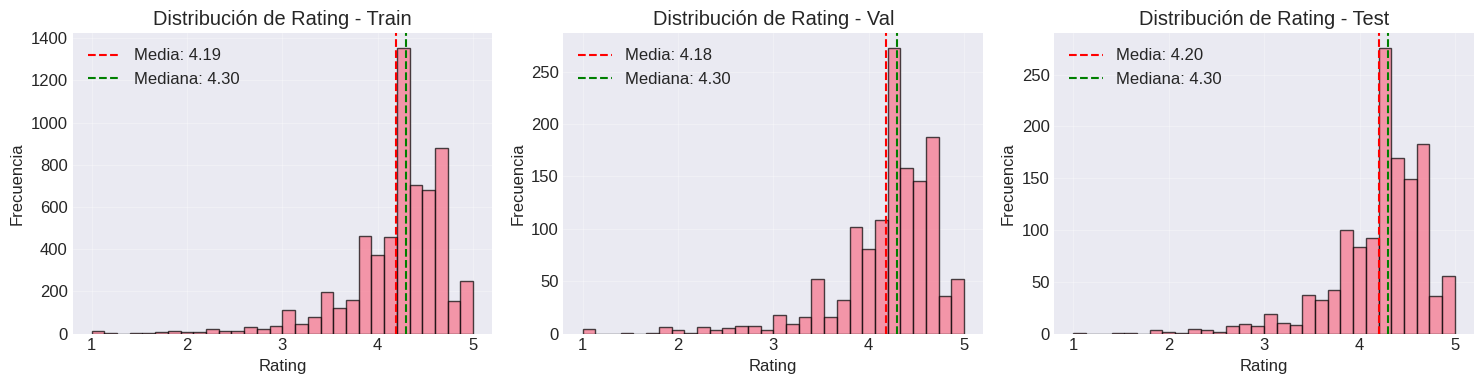


División estratificada completada exitosamente
IMPORTANTE: A partir de ahora, SOLO usaremos 'train' para calcular estadísticas


In [360]:
from sklearn.model_selection import train_test_split

print("=" * 80)
print("PASO 4: DIVISIÓN ESTRATIFICADA DEL DATASET".center(80))
print("=" * 80)

# Estado antes de dividir
print(f"\nDataset después de limpieza básica:")
print(f"  Total de registros: {len(df_clean):,}")
print(f"  Rating faltantes: {df_clean['Rating'].isnull().sum():,} ({df_clean['Rating'].isnull().sum()/len(df_clean)*100:.2f}%)")

# 1. ELIMINAR filas sin Rating (no podemos entrenar con ellas)
df_model = df_clean.dropna(subset=['Rating']).copy()
print(f"\nDespués de eliminar filas sin Rating:")
print(f"  Registros disponibles para modelado: {len(df_model):,}")
print(f"  Registros descartados: {len(df_clean) - len(df_model):,}")

# 2. DIVISIÓN ESTRATIFICADA: Train (70%), Temp (30%)
print("\n" + "-" * 80)
print("Dividiendo dataset (estratificado por Rating)...")
print("-" * 80)

# Crear bins de Rating para estratificación más robusta
df_model['rating_bin'] = pd.cut(df_model['Rating'], bins=[0, 3, 4, 4.5, 5], labels=['Low', 'Medium', 'High', 'VeryHigh'])

train, temp = train_test_split(
    df_model,
    test_size=0.30,
    stratify=df_model['rating_bin'],
    random_state=42
)

# 3. Dividir Temp en Val (50%) y Test (50%) → 15% y 15% del total
val, test = train_test_split(
    temp,
    test_size=0.50,
    stratify=temp['rating_bin'],
    random_state=42
)

# Eliminar columna auxiliar de binning
train = train.drop(columns=['rating_bin'])
val = val.drop(columns=['rating_bin'])
test = test.drop(columns=['rating_bin'])

# Reindexar para evitar problemas
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

print(f"\nDivisión completada:")
print(f"  Train: {len(train):,} registros ({len(train)/len(df_model)*100:.1f}%)")
print(f"  Val:   {len(val):,} registros ({len(val)/len(df_model)*100:.1f}%)")
print(f"  Test:  {len(test):,} registros ({len(test)/len(df_model)*100:.1f}%)")

# 4. VERIFICAR ESTRATIFICACIÓN (distribución de Rating debe ser similar)
print("\n" + "-" * 80)
print("Verificación de estratificación:")
print("-" * 80)

rating_dist = pd.DataFrame({
    'Train_mean': [train['Rating'].mean()],
    'Val_mean': [val['Rating'].mean()],
    'Test_mean': [test['Rating'].mean()],
    'Train_std': [train['Rating'].std()],
    'Val_std': [val['Rating'].std()],
    'Test_std': [test['Rating'].std()]
})
display(rating_dist.round(3))

# Visualización de distribuciones
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, data) in zip(axes, [('Train', train), ('Val', val), ('Test', test)]):
    ax.hist(data['Rating'], bins=30, alpha=0.7, edgecolor='black')
    ax.axvline(data['Rating'].mean(), color='red', linestyle='--', label=f'Media: {data["Rating"].mean():.2f}')
    ax.axvline(data['Rating'].median(), color='green', linestyle='--', label=f'Mediana: {data["Rating"].median():.2f}')
    ax.set_title(f'Distribución de Rating - {name}')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Frecuencia')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDivisión estratificada completada exitosamente")
print("IMPORTANTE: A partir de ahora, SOLO usaremos 'train' para calcular estadísticas")

### 2.3.7. Imputación de Valores Faltantes (Sin Data Leakage)

---

####  Calcular estadísticas **solo con `train`**

Todas las estadísticas utilizadas para la imputación (medianas, modas, etc.) se calculan **exclusivamente sobre el conjunto de entrenamiento (`train`)**.  
Esto evita que el modelo tenga acceso indirecto a información de validación o prueba (futuro), previniendo así **data leakage**.

> Ejemplo: las medianas de `Size` se obtienen por combinación `Category × Type` **solo a partir de `train`**, y luego se aplican a `val` y `test`.

---

#### Aplicar las mismas estadísticas a `val` y `test`

Las estadísticas aprendidas del `train` se reutilizan directamente en los conjuntos de validación y prueba.  
No se recalculan en esos conjuntos, lo que asegura **consistencia en la imputación** y **evita fuga de información**.

> Si una categoría no existe en `train`, se aplica una **mediana o moda global** (fallback), calculada también desde `train`.

---

#### Crear *flags* de valores faltantes **antes de imputar**

Antes de reemplazar los valores nulos, se generan columnas binarias (`_missing`) que indican la presencia de datos faltantes.  
Esto permite al modelo aprender si la ausencia de información tiene relevancia predictiva.

> Ejemplo de *flags*:  
> `size_missing`, `content_rating_missing`, `price_missing`, `android_ver_missing`, `current_ver_missing`.

---

#### Métodos de imputación por variable

| Variable | Método de imputación | Nivel de agrupación | Fallback |
|-----------|---------------------|---------------------|-----------|
| **`Size`** | Mediana | `Category × Type` | Mediana global |
| **`Content Rating`** | Moda | `Category` | Moda global |
| **`Android Ver`** | Moda | `Category` | Moda global |
| **`Current Ver`** | Moda | `Category` | Moda global |
| **`Price`** | `0` si `Free`, mediana si `Paid` | `Category` | Mediana global (`Paid`) |

Cada variable mantiene la misma política: **calcular con `train`, aplicar en `val` y `test`**.

---

#### Validación final de imputación

Después del proceso, se confirma que **ningún conjunto tenga valores faltantes**.  
Esto garantiza que la imputación fue exitosa y que los *flags* sean la única señal de ausencia original.

> Ejemplo de salida esperada:
> ```
> Train faltantes: 0
> Val faltantes: 0
> Test faltantes: 0
> ```

---

#### Beneficios de la metodología

| Aspecto | Beneficio |
|----------|------------|
| **Prevención de fuga de datos** | Solo se usan estadísticas del conjunto de entrenamiento. |
| **Consistencia entre conjuntos** | Mismo proceso aplicado a `train`, `val` y `test`. |
| **Trazabilidad de imputaciones** | Los flags `_missing` permiten capturar patrones de ausencia. |
| **Robustez general** | Cada variable se trata según su naturaleza (numérica o categórica). |



In [361]:
print("=" * 80)
print("PASO 4: IMPUTACIÓN DE VALORES FALTANTES (Sin Data Leakage)".center(80))
print("=" * 80)

print("\nMETODOLOGÍA:")
print("  1. Calcular estadísticas SOLO con train")
print("  2. Aplicar las mismas estadísticas a val y test")
print("  3. Crear flags de faltantes ANTES de imputar")
print("\n" + "=" * 80)

# ==============================================================================
# CREAR FLAGS DE FALTANTES (antes de imputar)
# ==============================================================================
print("\nCreando flags de valores faltantes...")

for df_name, df in [('train', train), ('val', val), ('test', test)]:
    df['size_missing'] = df['Size'].isnull().astype(int)
    df['content_rating_missing'] = df['Content Rating'].isnull().astype(int)
    df['android_ver_missing'] = df['Android Ver'].isnull().astype(int)
    df['current_ver_missing'] = df['Current Ver'].isnull().astype(int)
    df['price_missing'] = df['Price'].isnull().astype(int)

print("Flags creados en train, val y test")

# ==============================================================================
# 1. SIZE: Calcular medianas por Category × Type usando SOLO TRAIN
# ==============================================================================
print("\n" + "-" * 80)
print("Imputando SIZE (mediana por Category × Type)")
print("-" * 80)

# Calcular medianas SOLO con train
size_medians = train.groupby(['Category', 'Type'])['Size'].median()
size_global_median = train['Size'].median()

print(f"Medianas calculadas con train: {len(size_medians)} grupos")
print(f"Mediana global (fallback): {size_global_median:.2f} MB")

# Función para imputar usando mapping precalculado
def impute_size(df, medians_map, global_median):
    df = df.copy()
    for idx, row in df[df['Size'].isnull()].iterrows():
        cat, typ = row['Category'], row['Type']
        if (cat, typ) in medians_map.index:
            df.loc[idx, 'Size'] = medians_map.loc[(cat, typ)]
        else:
            df.loc[idx, 'Size'] = global_median
    return df

# Aplicar a train, val, test
train = impute_size(train, size_medians, size_global_median)
val = impute_size(val, size_medians, size_global_median)
test = impute_size(test, size_medians, size_global_median)

print(f"Size imputado en todos los conjuntos")
print(f"   Train faltantes: {train['Size'].isnull().sum()}")
print(f"   Val faltantes: {val['Size'].isnull().sum()}")
print(f"   Test faltantes: {test['Size'].isnull().sum()}")

# ==============================================================================
# 2. CONTENT RATING: Moda por Category (solo train)
# ==============================================================================
print("\n" + "-" * 80)
print("Imputando CONTENT RATING (moda por Category)")
print("-" * 80)

content_rating_modes = train.groupby('Category')['Content Rating'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
content_rating_global_mode = train['Content Rating'].mode()[0]

print(f"Modas calculadas con train: {len(content_rating_modes)} categorías")

def impute_content_rating(df, modes_map, global_mode):
    df = df.copy()
    for idx, row in df[df['Content Rating'].isnull()].iterrows():
        cat = row['Category']
        if cat in modes_map.index and pd.notna(modes_map.loc[cat]):
            df.loc[idx, 'Content Rating'] = modes_map.loc[cat]
        else:
            df.loc[idx, 'Content Rating'] = global_mode
    return df

train = impute_content_rating(train, content_rating_modes, content_rating_global_mode)
val = impute_content_rating(val, content_rating_modes, content_rating_global_mode)
test = impute_content_rating(test, content_rating_modes, content_rating_global_mode)

print(f"Content Rating imputado")

# ==============================================================================
# 3. ANDROID VER: Moda por Category (solo train)
# ==============================================================================
print("\n" + "-" * 80)
print("Imputando ANDROID VER (moda por Category)")
print("-" * 80)

android_ver_modes = train.groupby('Category')['Android Ver'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
android_ver_global_mode = train['Android Ver'].mode()[0]

def impute_android_ver(df, modes_map, global_mode):
    df = df.copy()
    for idx, row in df[df['Android Ver'].isnull()].iterrows():
        cat = row['Category']
        if cat in modes_map.index and pd.notna(modes_map.loc[cat]):
            df.loc[idx, 'Android Ver'] = modes_map.loc[cat]
        else:
            df.loc[idx, 'Android Ver'] = global_mode
    return df

train = impute_android_ver(train, android_ver_modes, android_ver_global_mode)
val = impute_android_ver(val, android_ver_modes, android_ver_global_mode)
test = impute_android_ver(test, android_ver_modes, android_ver_global_mode)

print(f"Android Ver imputado")

# ==============================================================================
# 4. CURRENT VER: Moda por Category (solo train)
# ==============================================================================
print("\n" + "-" * 80)
print("Imputando CURRENT VER (moda por Category)")
print("-" * 80)

current_ver_modes = train.groupby('Category')['Current Ver'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
current_ver_global_mode = train['Current Ver'].mode()[0]

def impute_current_ver(df, modes_map, global_mode):
    df = df.copy()
    for idx, row in df[df['Current Ver'].isnull()].iterrows():
        cat = row['Category']
        if cat in modes_map.index and pd.notna(modes_map.loc[cat]):
            df.loc[idx, 'Current Ver'] = modes_map.loc[cat]
        else:
            df.loc[idx, 'Current Ver'] = global_mode
    return df

train = impute_current_ver(train, current_ver_modes, current_ver_global_mode)
val = impute_current_ver(val, current_ver_modes, current_ver_global_mode)
test = impute_current_ver(test, current_ver_modes, current_ver_global_mode)

print(f"Current Ver imputado")

# ==============================================================================
# 5. PRICE: 0 si Free, mediana por Category si Paid (solo train)
# ==============================================================================
print("\n" + "-" * 80)
print("Imputando PRICE (0 si Free, mediana por Category si Paid)")
print("-" * 80)

# Calcular medianas de Price para apps Paid por Category (solo train)
price_medians_paid = train[train['Type'] == 'Paid'].groupby('Category')['Price'].median()
price_global_median_paid = train[train['Type'] == 'Paid']['Price'].median()

def impute_price(df, medians_paid_map, global_median_paid):
    df = df.copy()
    # Free apps → 0
    mask_free = (df['Type'] == 'Free') & df['Price'].isnull()
    df.loc[mask_free, 'Price'] = 0
    
    # Paid apps → mediana por Category
    for idx, row in df[(df['Type'] == 'Paid') & df['Price'].isnull()].iterrows():
        cat = row['Category']
        if cat in medians_paid_map.index and pd.notna(medians_paid_map.loc[cat]):
            df.loc[idx, 'Price'] = medians_paid_map.loc[cat]
        else:
            df.loc[idx, 'Price'] = global_median_paid
    return df

train = impute_price(train, price_medians_paid, price_global_median_paid)
val = impute_price(val, price_medians_paid, price_global_median_paid)
test = impute_price(test, price_medians_paid, price_global_median_paid)

print(f"Price imputado")

# ==============================================================================
# RESUMEN FINAL
# ==============================================================================
print("\n" + "=" * 80)
print("IMPUTACIÓN COMPLETADA SIN DATA LEAKAGE")
print("=" * 80)

print("\nValores faltantes restantes:")
for name, df in [('Train', train), ('Val', val), ('Test', test)]:
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if len(missing) == 0:
        print(f"  {name}: Sin valores faltantes")
    else:
        print(f"  {name}: {missing.to_dict()}")

print("\nFlags de trazabilidad creados:")
print(f"  - size_missing")
print(f"  - content_rating_missing")
print(f"  - android_ver_missing")
print(f"  - current_ver_missing")
print(f"  - price_missing")

           PASO 4: IMPUTACIÓN DE VALORES FALTANTES (Sin Data Leakage)           

METODOLOGÍA:
  1. Calcular estadísticas SOLO con train
  2. Aplicar las mismas estadísticas a val y test
  3. Crear flags de faltantes ANTES de imputar


Creando flags de valores faltantes...
Flags creados en train, val y test

--------------------------------------------------------------------------------
Imputando SIZE (mediana por Category × Type)
--------------------------------------------------------------------------------
Medianas calculadas con train: 59 grupos
Mediana global (fallback): 14.00 MB
Size imputado en todos los conjuntos
   Train faltantes: 0
   Val faltantes: 0
   Test faltantes: 0

--------------------------------------------------------------------------------
Imputando CONTENT RATING (moda por Category)
--------------------------------------------------------------------------------
Modas calculadas con train: 33 categorías
Content Rating imputado

-------------------------------

### 2.3.7. Transformaciones de Variables Numéricas (Sin Data Leakage)

En esta etapa se aplicaron transformaciones diseñadas para **reducir la asimetría**, **mejorar la interpretabilidad** y **preparar las variables numéricas** para los modelos, garantizando que ninguna transformación utilizara información de validación o prueba.

---

#### 2.3.7.1. Log-transformaciones

Se aplicaron transformaciones logarítmicas a variables con distribuciones altamente sesgadas y colas largas.  
Estas transformaciones se realizaron **de forma directa (sin estadísticos derivados)**, por lo que **no generan data leakage**.

**Variables transformadas:**
- `Reviews_log = log1p(Reviews)`
- `Installs_log = log1p(Installs Numeric)`
- `Size_log = log1p(Size)`

**Resultados en el conjunto de entrenamiento:**
- `Reviews_log`: Media = **8.26**, Mediana = **8.44**  
- `Installs_log`: Media = **12.18**, Mediana = **13.12**  
- `Size_log`: Media = **2.64**, Mediana = **2.64**

> Estas transformaciones suavizan la escala exponencial de las variables y mejoran la linealidad con respecto al target.


---

#### 2.3.7.3. Variables binarias derivadas

Se generaron nuevas variables booleanas basadas en reglas de negocio fijas, lo que facilita que el modelo capture relaciones no lineales simples.

**Variables creadas:**
- `is_free`: 1 si la app es gratuita (`Type == 'Free'`) → **5798 apps (93.2%)**
- `is_large_app`: 1 si el tamaño > 50 MB  
- `has_high_installs`: 1 si `Installs Numeric > 1,000,000` → **1793 apps (28.8%)**
- `is_top_category`: 1 si pertenece a `FAMILY` o `GAME`
- `is_everyone_rated`: 1 si `Content Rating == 'Everyone'`
- `large_and_popular`: combinación de `is_large_app` & `has_high_installs`

> Estas variables mejoran la capacidad del modelo para identificar patrones de negocio relevantes (por ejemplo, apps grandes y populares tienden a obtener mejores ratings).



In [362]:
print("=" * 80)
print("PASO 5: TRANSFORMACIONES DE VARIABLES NUMERICAS (Sin Data Leakage)".center(80))
print("=" * 80)

# ==============================================================================
# 1. LOG-TRANSFORMACIONES (sin data leakage, son transformaciones puntuales)
# ==============================================================================
print("\nAplicando transformaciones logarítmicas...")
print("-" * 80)

for df_name, df in [('train', train), ('val', val), ('test', test)]:
    df['Reviews_log'] = np.log1p(df['Reviews'])
    df['Installs_log'] = np.log1p(df['Installs Numeric'])
    df['Size_log'] = np.log1p(df['Size'])

print("Variables originales eliminadas tras log-transformación: Reviews, Installs Numeric, Size")
print("Transformaciones log aplicadas a train, val, test")
print(f"\n   Train - Reviews_log: Media {train['Reviews_log'].mean():.2f}, Mediana {train['Reviews_log'].median():.2f}")
print(f"   Train - Installs_log: Media {train['Installs_log'].mean():.2f}, Mediana {train['Installs_log'].median():.2f}")
print(f"   Train - Size_log: Media {train['Size_log'].mean():.2f}, Mediana {train['Size_log'].median():.2f}")


# ==============================================================================
# 2. VARIABLES BINARIAS (sin data leakage, son reglas fijas)
# ==============================================================================
print("\n\nCreando variables binarias...")
print("-" * 80)

for df_name, df in [('train', train), ('val', val), ('test', test)]:
    df['is_free'] = (df['Type'] == 'Free').astype(int)
    df['is_large_app'] = (df['Size'] > 50).astype(int)
    df['has_high_installs'] = (df['Installs Numeric'] > 1000000).astype(int)
    df['is_top_category'] = df['Category'].isin(['FAMILY', 'GAME']).astype(int)
    df['is_everyone_rated'] = (df['Content Rating'] == 'Everyone').astype(int)
    df['large_and_popular'] = (df['is_large_app'] & df['has_high_installs']).astype(int)

print("Variables binarias creadas")
print(f"\n   Train - is_free: {train['is_free'].sum()} ({train['is_free'].mean()*100:.1f}%)")
print(f"   Train - has_high_installs: {train['has_high_installs'].sum()} ({train['has_high_installs'].mean()*100:.1f}%)")

print("\nTransformaciones completadas sin data leakage")

       PASO 5: TRANSFORMACIONES DE VARIABLES NUMERICAS (Sin Data Leakage)       

Aplicando transformaciones logarítmicas...
--------------------------------------------------------------------------------
Variables originales eliminadas tras log-transformación: Reviews, Installs Numeric, Size
Transformaciones log aplicadas a train, val, test

   Train - Reviews_log: Media 8.26, Mediana 8.44
   Train - Installs_log: Media 12.18, Mediana 13.12
   Train - Size_log: Media 2.64, Mediana 2.64


Creando variables binarias...
--------------------------------------------------------------------------------
Variables binarias creadas

   Train - is_free: 5798 (93.2%)
   Train - has_high_installs: 1793 (28.8%)

Transformaciones completadas sin data leakage


### 2.3.8. Creacion de Variables Derivadas (Feature Engineering Básico)

Creamos nuevas variables combinando informacion existente para capturar patrones mas complejos, y eliminamos aquellas redundantes (procesos intermedios, reemplazadas por log1p, etc), que no nos brindan señal predictiva:


In [363]:
print("=" * 80)
print("PASO 6: FEATURE ENGINEERING (Sin Data Leakage)".center(80))
print("=" * 80)

for df_name, df in [('train', train), ('val', val), ('test', test)]:
    df['review_rate'] = df['Reviews'] / (df['Installs Numeric'] + 1)
    df['Last Updated Parsed'] = pd.to_datetime(df['Last Updated'], errors='coerce')
    reference_date = pd.to_datetime('2025-10-02')
    df['days_since_update'] = (reference_date - df['Last Updated Parsed']).dt.days
    df['update_recency'] = pd.cut(
        df['days_since_update'],
        bins=[-1, 30, 90, 180, 365, 730, 10000],
        labels=['<1 month', '1-3 months', '3-6 months', '6-12 months', '1-2 years', '>2 years']
    )
    df['size_per_install'] = df['Size'] / (df['Installs Numeric'] + 1)
    

print("\nCalculando popularity score (normalizadores desde train)...")
installs_min_train = train['Installs Numeric'].min()
installs_max_train = train['Installs Numeric'].max()
reviews_min_train = train['Reviews'].min()
reviews_max_train = train['Reviews'].max()

for df_name, df in [('train', train), ('val', val), ('test', test)]:
    installs_norm = (df['Installs Numeric'] - installs_min_train) / (installs_max_train - installs_min_train)
    reviews_norm = (df['Reviews'] - reviews_min_train) / (reviews_max_train - reviews_min_train)
    df['popularity_score'] = (installs_norm * 0.7 + reviews_norm * 0.3) * 100

print("Features derivadas creadas para obtener señal predictiva, sin data leakage")

print("------------------------")


print("Eliminación de columnas redudantes")

redundant_cols = [
    'Reviews', 'Installs Numeric', 'Size', 'Installs', 'Genres', 'Last Updated', 'Last Updated Parsed',
    'Current Ver', 'Android Ver', 'days_since_update'
]


for df in [train, val, test]:
    for col in redundant_cols:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)
print("Columnas redundantes eliminadas antes del encoding.")


                 PASO 6: FEATURE ENGINEERING (Sin Data Leakage)                 

Calculando popularity score (normalizadores desde train)...
Features derivadas creadas para obtener señal predictiva, sin data leakage
------------------------
Eliminación de columnas redudantes
Columnas redundantes eliminadas antes del encoding.


### 2.3.9 Manejo de categorías raras en la variable `Category`

En esta sección se agrupan las categorías poco frecuentes dentro de la variable `Category`.  
El objetivo es reducir el impacto del desbalance categórico y evitar que categorías con muy pocos registros afecten el aprendizaje del modelo.

Para ello, se define un **umbral (`threshold = 70`)** sobre el conjunto de entrenamiento.  
Todas las categorías con frecuencia menor a 70 se agrupan en una nueva categoría denominada **"Other"**.  
Posteriormente, se aplica el mismo mapeo al conjunto de validación y prueba, garantizando coherencia entre los tres splits y evitando fuga de información.


In [364]:
threshold = 70
freq_train = train['Category'].value_counts()
main_cats = freq_train[freq_train >= threshold].index.tolist()


def map_to_other(df, col, keep):
    df = df.copy()
    df[col] = df[col].apply(lambda x: x if x in keep else 'Other')
    return df

train = map_to_other(train, 'Category', set(main_cats))
val   = map_to_other(val,   'Category', set(main_cats))
test  = map_to_other(test,  'Category', set(main_cats))

print(f"Categorías 'Other' en train: {train['Category'].value_counts(normalize=True)['Other']}")
print(f"Categorías 'Other' en validation: {val['Category'].value_counts(normalize=True)['Other']}")
print(f"Categorías 'Other' en test: {test['Category'].value_counts(normalize=True)['Other']}")

Categorías 'Other' en train: 0.05976863753213368
Categorías 'Other' en validation: 0.05997001499250375
Categorías 'Other' en test: 0.06446776611694154


### 2.3.10 Manejo de categorías raras en la variable `Content Rating`

En esta sección se analizan las categorías presentes en la variable `Content Rating`, con el objetivo de identificar valores poco representativos que podrían introducir ruido en el modelo.

Durante la exploración se observaron las siguientes clases principales:
- **Everyone**
- **Teen**
- **Mature 17+**
- **Everyone 10+**

Y dos categorías extremadamente raras:
- **Adults only 18+** (2 registros)
- **Unrated** (1 registro)

Dado que estas últimas representan menos del **0.05 %** del total de observaciones, se decidió **eliminarlas directamente** en lugar de agruparlas bajo una categoría "Other".  
Esta decisión se justifica porque su frecuencia es demasiado baja para aportar señal estadística y no se espera que aparezcan con relevancia en datos futuros.

In [365]:
train = train[~train['Content Rating'].isin(['Adults only 18+', 'Unrated'])].copy()
val   = val[~val['Content Rating'].isin(['Adults only 18+', 'Unrated'])].copy()
test  = test[~test['Content Rating'].isin(['Adults only 18+', 'Unrated'])].copy()

print(f"Content Rating en train: {train['Content Rating'].value_counts()}")
print("-----")
print(f"Content Rating en validation: {val['Content Rating'].value_counts()}")
print("-----")
print(f"Content Rating en test: {test['Content Rating'].value_counts()}")


Content Rating en train: Content Rating
Everyone        4960
Teen             714
Mature 17+       293
Everyone 10+     254
Name: count, dtype: int64
-----
Content Rating en validation: Content Rating
Everyone        1086
Teen             147
Mature 17+        56
Everyone 10+      45
Name: count, dtype: int64
-----
Content Rating en test: Content Rating
Everyone        1049
Teen             161
Mature 17+        62
Everyone 10+      61
Name: count, dtype: int64


### 2.3.11 Resumen final del dataset dividido (Train / Validation / Test)

En esta sección se presenta un **resumen general** del estado final de los datos tras todo el proceso de limpieza, depuración y división en conjuntos de entrenamiento, validación y prueba.  
El objetivo es validar que las transformaciones previas (eliminación de duplicados, tratamiento de valores faltantes, corrección de outliers y manejo de variables categóricas) se hayan aplicado correctamente y que las tres particiones mantengan coherencia estructural y estadística.



In [366]:
# ==============================================
# 2.3.11 - Resumen final del dataset dividido
# ORIGINAL vs (TRAIN / VALIDATION / TEST)
# ==============================================

import pandas as pd
from IPython.display import display

print("=" * 80)
print("RESUMEN FINAL: DATASET DIVIDIDO (Train / Validation / Test)".center(80))
print("=" * 80)

print("\n" + "=" * 40)
print("COMPARACIÓN: ORIGINAL vs SPLITS")
print("=" * 40)

# ---------- Función de resumen por dataset ----------
def get_summary(df, name):
    return [
        name,
        f"{len(df):,}",
        f"{len(df.columns)}",
        f"{df.duplicated().sum():,}",
        f"{df['Rating'].isnull().sum():,}" if 'Rating' in df.columns else "N/A",
        f"{df['Size'].isnull().sum():,}" if 'Size' in df.columns else "N/A",
        f"{df['Price'].isnull().sum():,}" if 'Price' in df.columns else "N/A",
        f"{df['Type'].isnull().sum():,}" if 'Type' in df.columns else "N/A",
        f"{((df['Rating'] > 5) | (df['Rating'] < 1)).sum():,}" if 'Rating' in df.columns else "N/A",
        f"{df.memory_usage(deep=True).sum() / 1024**2:.2f}"
    ]

# ---------- Construcción de la tabla comparativa ----------
summary_rows = [
    get_summary(applications_data, "Original"),
    get_summary(train, "Train"),
    get_summary(val, "Validation"),
    get_summary(test, "Test")
]

comparison = pd.DataFrame(
    summary_rows,
    columns=[
        "Conjunto",
        "Total de registros",
        "Total de columnas",
        "Duplicados",
        "Rating faltantes",
        "Size faltantes",
        "Price faltantes",
        "Type faltantes",
        "Ratings inválidos (>5 o <1)",
        "Memoria (MB)"
    ]
)

display(comparison)

# ---------- Listado de features por split ----------
print("\n" + "=" * 40)
print("LISTADO DE FEATURES EN CADA CONJUNTO")
print("=" * 40)
for name, df in [('Train', train), ('Validation', val), ('Test', test)]:
    print(f"\n{name}: Total de features = {len(df.columns)}")
    print("columnas:")
    for i, col in enumerate(df.columns, 1):
        print(f"  {i:3d}. {col}")
    if len(df.columns) > 30:
        print("  ...")
    print("Últimas 5 columnas:")
    for i, col in enumerate(df.columns[-5:], len(df.columns)-4):
        print(f"  {i:3d}. {col}")

# ---------- Estadísticas descriptivas (numéricas) ----------
print("\n" + "=" * 40)
print("ESTADÍSTICAS DESCRIPTIVAS (Variables numéricas - Train)")
print("=" * 40)

# Variables numéricas más relevantes para el análisis
key_numeric = [
    'Rating', 
    'Price', 
    'review_rate', 
    'size_per_install', 
    'popularity_score',
    'Reviews_log',
    'Installs_log',
    'Size_log'
]

# Filtrar solo las columnas que existen realmente en el dataset
available_numeric = [col for col in key_numeric if col in train.columns]

# Mostrar la descripción
if available_numeric:
    print(f"\nVariables incluidas en el análisis: {', '.join(available_numeric)}")
    display(train[available_numeric].describe().round(3).T)
else:
    print("No se encontraron las columnas seleccionadas en el conjunto de entrenamiento.")

# ---------- Mensaje final ----------
print("\n" + "=" * 80)
print("TRANSFORMACIÓN Y DIVISIÓN COMPLETADAS EXITOSAMENTE")
print("=" * 80)
print(f"\nConjuntos disponibles: train, val, test")
print(f"Dimensiones finales: Train={train.shape[0]:,}, Val={val.shape[0]:,}, Test={test.shape[0]:,}")
print(f"Memoria utilizada (train): {train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


          RESUMEN FINAL: DATASET DIVIDIDO (Train / Validation / Test)           

COMPARACIÓN: ORIGINAL vs SPLITS


,Conjunto,Total de registros,Total de columnas,Duplicados,Rating faltantes,Size faltantes,Price faltantes,Type faltantes,Ratings inválidos (>5 o <1),Memoria (MB)
0,Original,"10,841",14,483,"1,474","1,696",1,1,1,5.98
1,Train,"6,221",24,1,0,N/A,0,0,0,2.40
2,Validation,"1,334",24,0,0,N/A,0,0,0,0.50
3,Test,"1,333",24,0,0,N/A,0,0,0,0.52



LISTADO DE FEATURES EN CADA CONJUNTO

Train: Total de features = 24
columnas:
    1. App
    2. Category
    3. Rating
    4. Type
    5. Price
    6. Content Rating
    7. size_missing
    8. content_rating_missing
    9. android_ver_missing
   10. current_ver_missing
   11. price_missing
   12. Reviews_log
   13. Installs_log
   14. Size_log
   15. is_free
   16. is_large_app
   17. has_high_installs
   18. is_top_category
   19. is_everyone_rated
   20. large_and_popular
   21. review_rate
   22. update_recency
   23. size_per_install
   24. popularity_score
Últimas 5 columnas:
   20. large_and_popular
   21. review_rate
   22. update_recency
   23. size_per_install
   24. popularity_score

Validation: Total de features = 24
columnas:
    1. App
    2. Category
    3. Rating
    4. Type
    5. Price
    6. Content Rating
    7. size_missing
    8. content_rating_missing
    9. android_ver_missing
   10. current_ver_missing
   11. price_missing
   12. Reviews_log
   13. Installs_log

,count,mean,std,min,25%,50%,75%,max
Rating,6221.00,4.19,0.52,1.00,4.00,4.30,4.50,5.00
Price,6221.00,1.06,17.30,0.00,0.00,0.00,0.00,399.99
review_rate,6221.00,0.04,0.07,0.00,0.01,0.02,0.04,2.00
size_per_install,6221.00,0.03,0.32,0.00,0.00,0.00,0.00,12.50
popularity_score,6221.00,1.29,6.71,0.00,0.00,0.04,0.38,100.00
Reviews_log,6221.00,8.26,3.82,0.69,5.14,8.44,11.16,18.17
Installs_log,6221.00,12.18,3.81,0.69,9.21,13.12,15.43,20.72
Size_log,6221.00,2.65,1.01,0.01,1.93,2.64,3.40,4.62



TRANSFORMACIÓN Y DIVISIÓN COMPLETADAS EXITOSAMENTE

Conjuntos disponibles: train, val, test
Dimensiones finales: Train=6,221, Val=1,334, Test=1,333
Memoria utilizada (train): 2.40 MB


### 2.3.12 Análisis de relevancia de variables mediante Información Mutua

En esta etapa se aplicó la métrica de **Información Mutua** para cuantificar la dependencia estadística entre cada variable numérica y la variable objetivo `Rating`.  
Este análisis permite identificar qué variables aportan mayor información al modelo, sin asumir relaciones lineales, ayudando a seleccionar los predictores más relevantes antes del entrenamiento.

#### 2.3.12.1. Interpretación de resultados

La gráfica muestra la **importancia relativa de cada variable** según su grado de información compartida con `Rating`.  
Se observa que:

- **`popularity_score`** es la variable más influyente, con el valor de información mutua más alto (~0.34). Esto indica una fuerte relación entre la popularidad de la app (descargas y reseñas combinadas) y su calificación promedio.  
- **`Reviews_log`** y **`review_rate`** también presentan una asociación significativa con el rating, lo que refuerza la idea de que la participación y satisfacción de los usuarios están estrechamente ligadas a la puntuación final.  
- Variables como **`Installs_log`**, **`size_per_install`** y **`has_high_installs`** muestran una contribución media, aportando información adicional relacionada con la escala de uso y la eficiencia de la aplicación.  
- En contraste, variables como **`Price`**, **`price_missing`**, **`is_top_category`** o **`current_ver_missing`** tienen una influencia muy baja, lo que sugiere que su aporte al modelo sería marginal.


['Price', 'size_missing', 'content_rating_missing', 'android_ver_missing', 'current_ver_missing', 'price_missing', 'Reviews_log', 'Installs_log', 'Size_log', 'is_free', 'is_large_app', 'has_high_installs', 'is_top_category', 'is_everyone_rated', 'large_and_popular', 'review_rate', 'size_per_install', 'popularity_score']


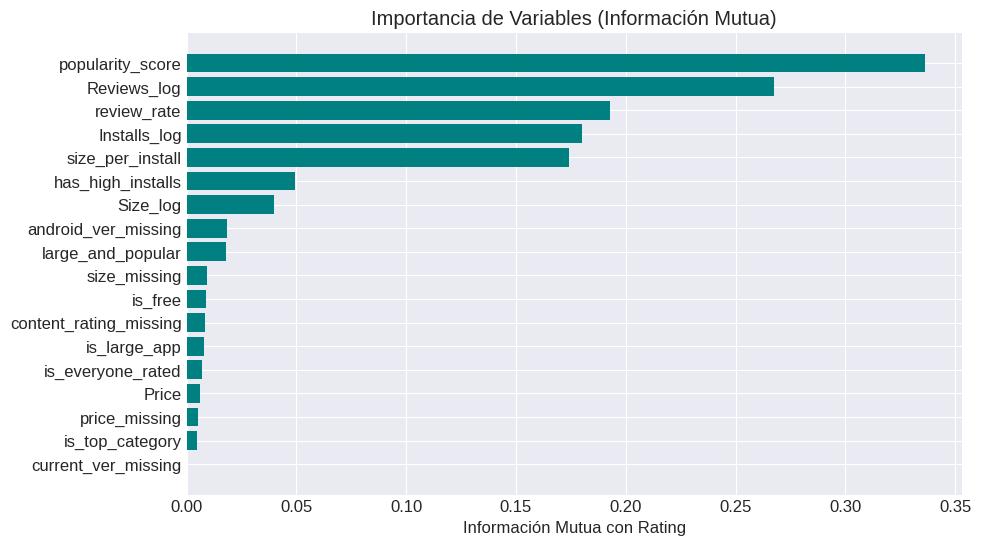

,Variable,MI_Score
17,popularity_score,0.34
6,Reviews_log,0.27
15,review_rate,0.19
7,Installs_log,0.18
16,size_per_install,0.17
11,has_high_installs,0.05
8,Size_log,0.04
3,android_ver_missing,0.02
14,large_and_popular,0.02
1,size_missing,0.01



Variables con baja información mutua (<0.01) que pueden eliminarse inicialmente:
  - size_missing
  - is_free
  - content_rating_missing
  - is_large_app
  - is_everyone_rated
  - Price
  - price_missing
  - is_top_category
  - current_ver_missing

Variables seleccionadas para modelado inicial (9):
['popularity_score', 'Reviews_log', 'review_rate', 'Installs_log', 'size_per_install', 'has_high_installs', 'Size_log', 'android_ver_missing', 'large_and_popular']


In [367]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

# Selección de variables predictoras: solo numéricas (int, float)
target = 'Rating'
ignore_cols = [target]
X_cols = [
    col for col in train.columns
    if col not in ignore_cols
    and pd.api.types.is_numeric_dtype(train[col])
]

print(X_cols)

X = train[X_cols].copy()
y = train[target]

# Calcular información mutua
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_df = pd.DataFrame({'Variable': X_cols, 'MI_Score': mi_scores}).sort_values('MI_Score', ascending=False)

# Visualización
plt.figure(figsize=(10, 6))
plt.barh(mi_df['Variable'], mi_df['MI_Score'], color='teal')
plt.xlabel('Información Mutua con Rating')
plt.title('Importancia de Variables (Información Mutua)')
plt.gca().invert_yaxis()
plt.show()

# Mostrar tabla ordenada
display(mi_df)

# Eliminar variables con MI muy baja (<0.01)
low_mi_vars = mi_df[mi_df['MI_Score'] < 0.01]['Variable'].tolist()
print(f"\nVariables con baja información mutua (<0.01) que pueden eliminarse inicialmente:")
for v in low_mi_vars:
    print(f"  - {v}")

# Variables relevantes para modelado
selected_vars = mi_df[mi_df['MI_Score'] >= 0.01]['Variable'].tolist()
print(f"\nVariables seleccionadas para modelado inicial ({len(selected_vars)}):")
print(selected_vars)

### 2.3.13 Verificación de correlación y análisis de multicolinealidad

En esta etapa se evaluó la **correlación lineal entre las variables seleccionadas** tras el análisis de información mutua, con el fin de detectar posibles casos de **multicolinealidad**.  
La multicolinealidad ocurre cuando dos o más variables están fuertemente correlacionadas entre sí, lo que puede distorsionar la interpretación de los modelos y afectar la estabilidad de los coeficientes en algoritmos lineales (por ejemplo, regresión o modelos basados en pesos).

Para ello, se calculó la **matriz de correlación de Pearson** considerando únicamente las variables numéricas seleccionadas y se visualizó mediante un mapa de calor.

#### 2.3.13.1. Interpretación de la matriz

- Se observa una **alta correlación entre `Reviews_log` e `Installs_log` (r ≈ 0.96)**, lo que indica que ambas variables transmiten información muy similar: las aplicaciones con muchas reseñas suelen tener también un gran número de instalaciones.  
  Por tanto, mantener ambas podría ser redundante en modelos sensibles a multicolinealidad.  
- También existe una correlación considerable entre **`has_high_installs`** y las variables anteriores (`Installs_log` y `Reviews_log`), dado que esta variable binaria deriva del mismo concepto (nivel alto de descargas).  
- El resto de las variables presentan correlaciones moderadas o bajas, lo cual es positivo: **no se evidencia colinealidad severa** fuera del grupo relacionado con las métricas de descargas y reseñas.  
- Variables como `review_rate`, `size_per_install`, `popularity_score`, `Size_log` y `large_and_popular` muestran relaciones débiles o independientes entre sí, lo que las hace adecuadas para conservarlas.

#### 2.3.13.2. Decisión
Se toma la decisión de eliminar Installs_log dado que Reviews_Log explica su comportamiento.

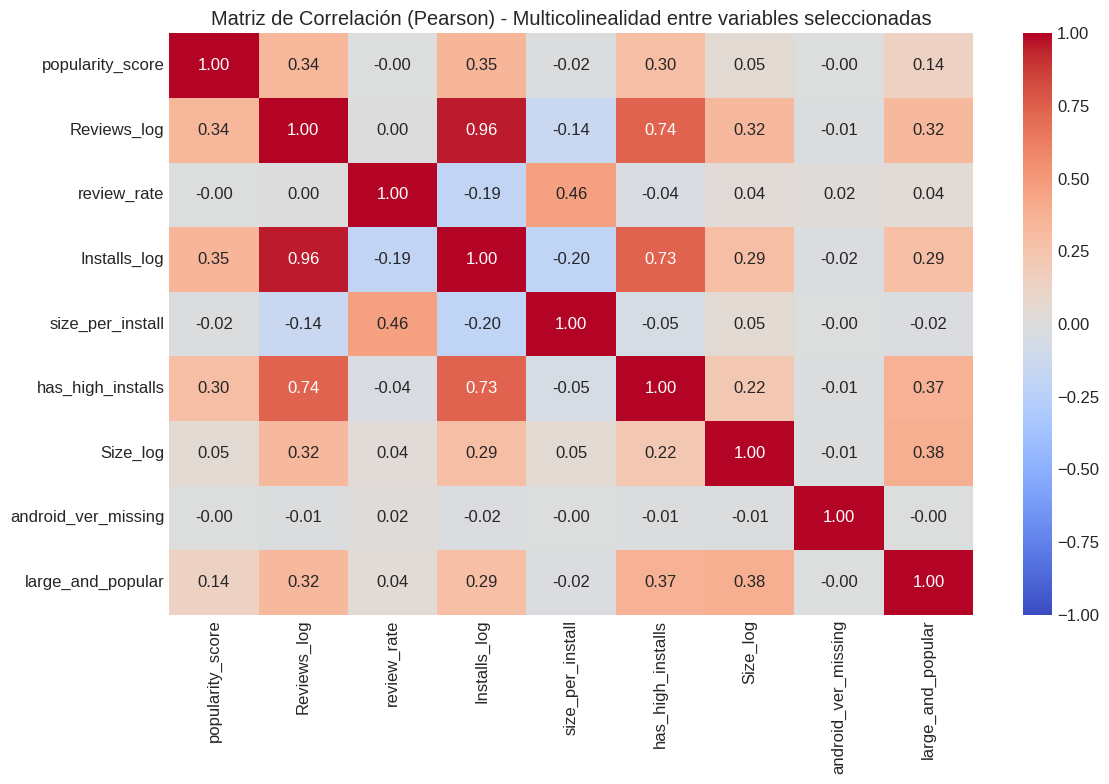


Pares de variables con posible multicolinealidad (|corr| > 0.8):
  • Reviews_log y Installs_log: +0.96


In [368]:
# Análisis de multicolinealidad entre variables seleccionadas por información mutua
def multicollinearity_analysis(df, selected_vars):
    """
    Analiza la multicolinealidad entre las variables seleccionadas (sin incluir el target).
    """
    # Solo variables numéricas seleccionadas (sin el target)
    selected_numeric = [v for v in selected_vars if pd.api.types.is_numeric_dtype(df[v])]
    corr_matrix = df[selected_numeric].corr(method='pearson')

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title('Matriz de Correlación (Pearson) - Multicolinealidad entre variables seleccionadas')
    plt.tight_layout()
    plt.show()

    # Mostrar pares con alta correlación (|corr| > 0.8)
    print("\nPares de variables con posible multicolinealidad (|corr| > 0.8):")
    high_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    for col in high_corr.columns:
        for idx in high_corr.index:
            corr_val = high_corr.loc[idx, col]
            if abs(corr_val) > 0.8:
                print(f"  • {idx} y {col}: {corr_val:+.2f}")

# Ejecutar el análisis de multicolinealidad solo para las variables seleccionadas
multicollinearity_analysis(train, selected_vars)

In [369]:
for df in [train, val, test]:
    if 'Installs_log' in df.columns:
        df.drop(columns=['Installs_log'], inplace=True)
print("Columna 'Installs_log' eliminada por multicolinealidad con 'Reviews_log'.")

Columna 'Installs_log' eliminada por multicolinealidad con 'Reviews_log'.


### 2.3.14 Codificación de variables categóricas (One-Hot Encoding)

En esta fase se transformaron las variables categóricas del conjunto de datos en formato numérico mediante **One-Hot Encoding (OHE)**.  
Este proceso es esencial para los modelos de machine learning que requieren valores numéricos de entrada, permitiendo representar cada categoría como una columna binaria independiente.

#### 2.3.14.1. Proceso aplicado

1. Se identificaron todas las variables categóricas (`object` o `category`) excepto el identificador `App`.  
2. Se aplicó **One-Hot Encoding** sobre estas variables, creando una columna por cada categoría posible.  
3. Para garantizar consistencia entre los conjuntos `train`, `validation` y `test`, se implementó una función que:
   - Asegura que **todos los conjuntos contengan las mismas columnas codificadas**.  
   - Agrega columnas faltantes con valores `0` en caso de que una categoría no esté presente en un conjunto específico.  
   - Elimina cualquier columna extra que no esté en la estructura original de `train`.  
4. Finalmente, los tres conjuntos (`train`, `val`, `test`) quedaron alineados en número y orden de columnas, listos para el modelado.

#### 2.3.14.2. Resultado

Tras la codificación:
- Se convirtieron correctamente todas las variables categóricas a formato numérico.  
- El número de columnas aumentó, reflejando las nuevas variables dummy generadas por OHE.  
- Se verificó que la estructura final es idéntica en los tres conjuntos:  

| Conjunto | Total de columnas |
|-----------|------------------|
| **Train** | 57 |
| **Validation** | igual a Train |
| **Test** | igual a Train |


In [370]:
cat_cols = [
    c for c in train.columns
    if (train[c].dtype == 'object' or str(train[c].dtype) == 'category')
    and c not in ['App']
]

print(cat_cols)
train_dummies = pd.get_dummies(train, columns=cat_cols, drop_first=False)
dummy_cols = [col for col in train_dummies.columns if col not in train.columns or col in cat_cols]

def align_dummies(df, cat_cols, dummy_cols):
    df_dummies = pd.get_dummies(df, columns=cat_cols, drop_first=False)
    for col in dummy_cols:
        if col not in df_dummies.columns:
            df_dummies[col] = 0
    extra_cols = set(df_dummies.columns) - set(train_dummies.columns)
    df_dummies = df_dummies.drop(columns=list(extra_cols))
    df_dummies = df_dummies[train_dummies.columns]
    return df_dummies

val_dummies = align_dummies(val, cat_cols, dummy_cols)
test_dummies = align_dummies(test, cat_cols, dummy_cols)

train = train_dummies.copy()
val = val_dummies.copy()
test = test_dummies.copy()

print(f"Variables categóricas codificadas y alineadas: Train={train.shape[1]}, Val={val.shape[1]}, Test={test.shape[1]}")


['Category', 'Type', 'Content Rating', 'update_recency']
Variables categóricas codificadas y alineadas: Train=56, Val=56, Test=56
